# Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import GRU, Bidirectional

# Read Dataset

In [ ]:
train_data = pd.read_csv('/kaggle/input/datasett/train_data.csv')
val_data = pd.read_csv('/kaggle/input/datasett/val_data.csv')
test_data = pd.read_csv('/kaggle/input/datasett/test_data.csv')

In [ ]:
train_data.head()

preprocessed_text  label
0  love job love kid time feel like person leave ...      0
1                  think girl feel way guy like tell      2
2                                     feel depressed      0
3      feel come assaulted wall wildly dynamic sound      4
4  feel throw away rotten vegetable double realiz...      0

In [ ]:
val_data.head()

preprocessed_text  label
0          struggle lot writer block feeling inspire      1
1                               want know feel needy      0
2  discover bloke life feel pretty pissed thou de...      3
3                            hope feel tomorrow well      1
4                                      feel honoured      1

In [ ]:
test_data.head()

preprocessed_text  label
0                      feel particularly neurotic      4
1  feel little overwhelmed think lot easy welding      4
2                        feel important influence      1
3                                     feel afraid      4
4                                     feel lonely      0

In [ ]:
train_data['label'].value_counts()

label
1    112620
0     96787
3     45781
4     38127
2     27598
5     11967
Name: count, dtype: int64

In [ ]:
val_data['label'].value_counts()

label
1    14078
0    12098
3     5722
4     4766
2     3450
5     1496
Name: count, dtype: int64

In [ ]:
test_data['label'].value_counts()

label
1    14078
0    12099
3     5723
4     4766
2     3449
5     1496
Name: count, dtype: int64

# TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) adalah cara untuk memberi bobot pada kata dalam teks. **TF** menghitung seberapa sering kata muncul di sebuah dokumen, sementara **IDF** melihat seberapa jarang kata itu muncul di seluruh dokumen. Gabungan keduanya membantu memilih kata-kata penting yang relevan untuk sebuah dokumen, sambil mengabaikan kata-kata umum seperti "the" atau "and". Jadi, TF-IDF itu semacam filter pintar buat fokus ke kata-kata yang benar-benar berarti

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['preprocessed_text'])

X_val_tfidf = tfidf_vectorizer.transform(val_data['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['preprocessed_text'])

X_train_tfidf = X_train_tfidf.toarray()
X_val_tfidf = X_val_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_val_tfidf: {X_val_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Shape of X_train_tfidf: (332880, 5000)
Shape of X_val_tfidf: (41610, 5000)
Shape of X_test_tfidf: (41611, 5000)


Kami menggunakan 5000 fitur buat menjaga keseimbangan antara efisiensi model dan performanya. Karena datasetnya besar, dengan TF-IDF kami pilih 5000 kata paling relevan supaya model fokus ke informasi penting, sambil ngurangin noise dari kata-kata yang nggak signifikan. Pilihan ini juga bikin model nggak terlalu berat secara komputasi atau boros memori, terutama kalau mau dilatih pakai arsitektur deep learning seperti LSTM atau GRU. Intinya, ini cara biar model tetap akurat tanpa bikin komputasi jadi ribet.

In [ ]:
input_dim = X_train_tfidf.shape[1]

`input_dim = X_train_tfidf.shape[1]` digunakan untuk menentukan jumlah fitur input model agar sesuai dengan dimensi representasi TF-IDF. Ini memastikan model dapat memproses data dengan jumlah fitur yang sama seperti hasil vektorisasi TF-IDF.

Untuk pemodelan, kami menguji empat arsitektur deep learning: GRU, LSTM, Bi-GRU, dan Bi-LSTM dengan representasi teks yang telah kami bahas sebelumnya.

Arsitektur model meliputi:
- Embedding layer dan reshaping layer untuk memproses data input.
- Recurrent layer dengan 64 units untuk menangkap pola urutan.
- Dense layer dengan 128 units dan activation ReLU untuk ekstraksi fitur.
- Dropout layer (0.5) untuk mencegah overfitting.
- Softmax output layer untuk mengklasifikasikan enam emosi.

Untuk kompilasi model, kami menggunakan:
- **Adam optimizer**
- **Sparse categorical cross-entropy** sebagai loss function
- **Accuracy** sebagai evaluation metric

Kami melakukan hyperparameter tuning dengan:
- Tiga variasi learning rate dan batch size
- Hingga 100 epochs

Untuk menghindari overfitting, kami menerapkan **early stopping** dengan patience 5 epochs, serta mempertahankan bobot dari epoch terbaik berdasarkan validation loss.

In [ ]:
def create_gru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Reshape((1, input_dim)))
    model.add(layers.GRU(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_bigru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Reshape((1, input_dim)))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Reshape((1, input_dim)))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_bilstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Reshape((1, input_dim)))
    model.add(Bidirectional(layers.LSTM(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
def train_and_evaluate(input_dim, batch_size, learning_rate, epochs, X_train, y_train, X_val, y_val, X_test, y_test, model_type='gru'):
    # Select the model type
    if model_type == 'gru':
        model = create_gru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bigru':
        model = create_bigru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'lstm':
        model = create_lstm_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bilstm':
        model = create_bilstm_model(input_dim, learning_rate=learning_rate)
    else:
        raise ValueError("Invalid model_type. Choose 'gru', 'bigru', 'lstm', or 'bilstm'.")

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Plot training history
    print("\nTraining History:\n")
    plot_training_history(history)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Classification report
    report = classification_report(y_test, y_pred_labels)

    print("\nClassification Report:\n")
    print(report)

    # Calculate AUC
    try:
        test_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=6), y_pred, multi_class='ovr')
    except ValueError:
        test_auc = "AUC not available for fewer than two classes"

    # Metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    precision = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['recall']
    f1_score = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['f1-score']

    metrics = {
        'Train Loss': train_loss,
        'Val Loss': val_loss,
        'Test Loss': test_loss,
        'AUC': test_auc,
        'Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    # Print metrics
    print("\nMetrics:\n")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    print("")

    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test, num_classes=6)

    return model, metrics, history

## GRU

In [ ]:
tfidf_gru_model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)                  │ (None, 1, 5000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │         972,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945,300 (11.24 MB)

 Trainable params: 981,766 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,963,534 (7.49 MB)

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/step - accuracy: 0.8293 - loss: 0.4994 - val_accuracy: 0.8795 - val_loss: 0.3404
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/step - accuracy: 0.8807 - loss: 0.3495 - val_accuracy: 0.8838 - val_loss: 0.3485
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - accuracy: 0.8839 - loss: 0.3348 - val_accuracy: 0.8813 - val_loss: 0.3951
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.8867 - loss: 0.3240 - val_accuracy: 0.8807 - val_loss: 0.4816
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.8889 - loss: 0.3192 - val_accuracy: 0.8821 - val_loss: 0.5454
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - accuracy: 0.8893 - loss: 0.3214 - val_accuracy: 0.8797 - val_loss: 0.7194
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



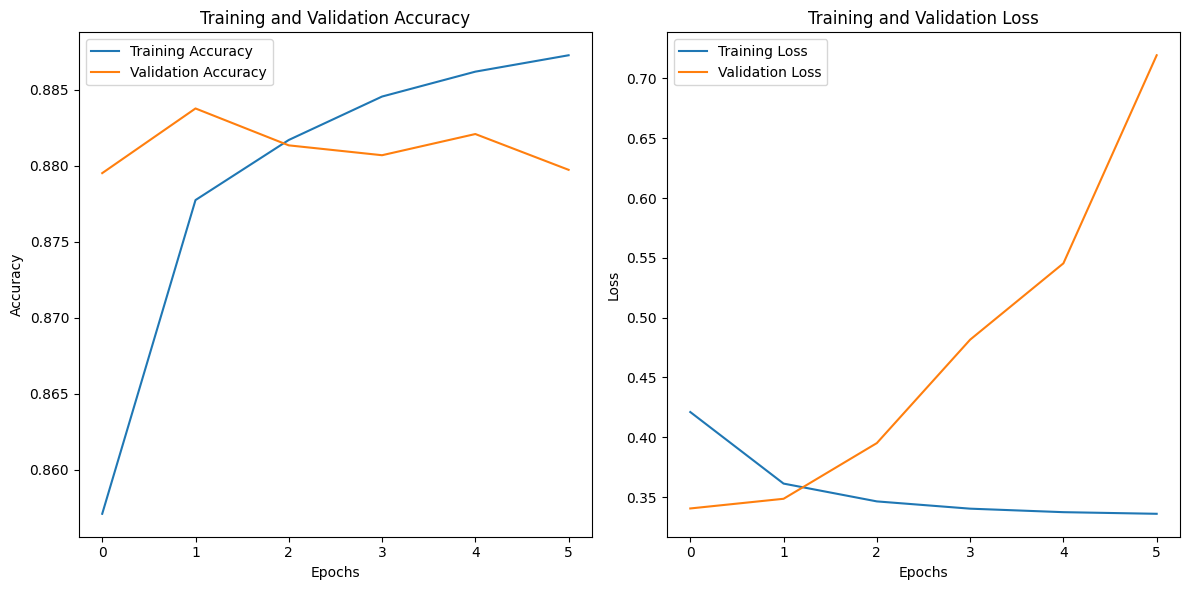

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     12099
           1       0.91      0.89      0.90     14078
           2       0.75      0.79      0.77      3449
           3       0.85      0.93      0.89      5723
           4       0.93      0.75      0.83      4766
           5       0.74      0.79      0.77      1496

    accuracy                           0.88     41611
   macro avg       0.85      0.85      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.3359713852405548
Val Loss: 0.7193939089775085
Test Loss: 0.3391748070716858
AUC: 0.9855474289224654
Accuracy: 0.8795030117034912
Precision: 0.8820732186392979
Recall: 0.8795030160294153
F1-Score: 0.8792571633796604

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


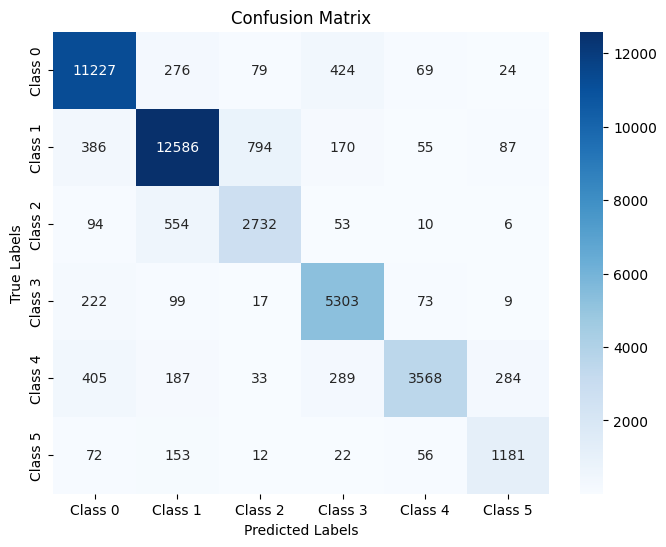


Model saved as 'tfidf_gru_model_1.h5'



In [ ]:
tfidf_gru_model_1, tfidf_gru_metrics_1, tfidf_gru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_1.save('tfidf_gru_model_1.h5')
print("\nModel saved as 'tfidf_gru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 149s 4ms/step - accuracy: 0.8359 - loss: 0.4293 - val_accuracy: 0.8918 - val_loss: 0.2457
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/step - accuracy: 0.8943 - loss: 0.2382 - val_accuracy: 0.8907 - val_loss: 0.2375
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 151s 4ms/step - accuracy: 0.9001 - loss: 0.2162 - val_accuracy: 0.8927 - val_loss: 0.2366
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 149s 4ms/step - accuracy: 0.9043 - loss: 0.2026 - val_accuracy: 0.8929 - val_loss: 0.2422
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/step - accuracy: 0.9088 - loss: 0.1908 - val_accuracy: 0.8887 - val_loss: 0.2487
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 150s 4ms/step - accuracy: 0.9123 - loss: 0.1800 - val_accuracy: 0.8884 - val_loss: 0.2668
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 150s 4ms/step - accuracy: 0.9151 - loss: 0.1708 - val_accuracy: 0.8908 - val_loss: 0.2789
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 147s 4ms/s

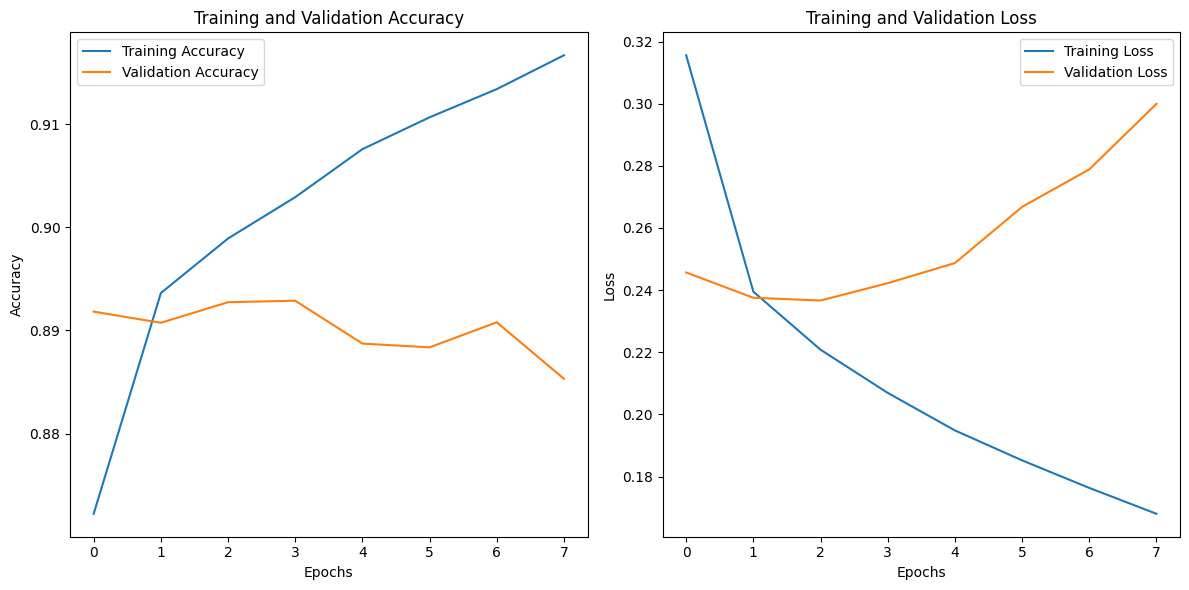

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.92      0.90      0.91     14078
           2       0.75      0.84      0.79      3449
           3       0.89      0.90      0.89      5723
           4       0.84      0.85      0.85      4766
           5       0.82      0.64      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.86      0.84      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.167997345328331
Val Loss: 0.29992932081222534
Test Loss: 0.23696915805339813
AUC: 0.99220050463635
Accuracy: 0.8908461928367615
Precision: 0.8917578330339965
Recall: 0.8908461704837664
F1-Score: 0.8906841695293111

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


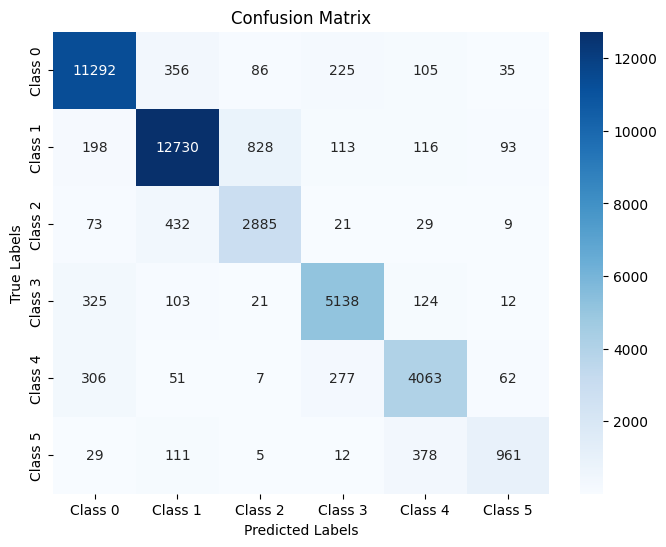


Model saved as 'tfidf_gru_model_2.h5'



In [ ]:
tfidf_gru_model_2, tfidf_gru_metrics_2, tfidf_gru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_2.save('tfidf_gru_model_2.h5')
print("\nModel saved as 'tfidf_gru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 148s 4ms/step - accuracy: 0.7202 - loss: 0.7706 - val_accuracy: 0.8886 - val_loss: 0.2596
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.8950 - loss: 0.2588 - val_accuracy: 0.8884 - val_loss: 0.2385
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - accuracy: 0.9000 - loss: 0.2283 - val_accuracy: 0.8898 - val_loss: 0.2320
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.9018 - loss: 0.2155 - val_accuracy: 0.8910 - val_loss: 0.2301
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - accuracy: 0.9021 - loss: 0.2124 - val_accuracy: 0.8932 - val_loss: 0.2297
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.9030 - loss: 0.2094 - val_accuracy: 0.8909 - val_loss: 0.2311
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.9046 - loss: 0.2051 - val_accuracy: 0.8927 - val_loss: 0.2317
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 170s 4ms/s

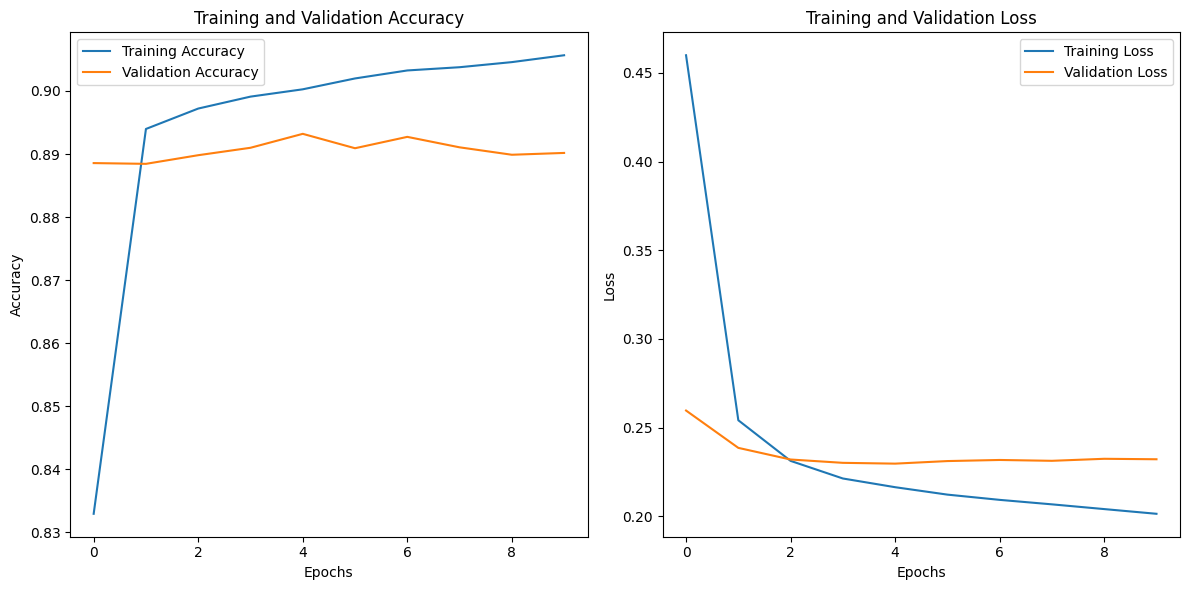

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.90      0.93      0.92     14078
           2       0.85      0.69      0.76      3449
           3       0.89      0.90      0.89      5723
           4       0.86      0.82      0.84      4766
           5       0.71      0.78      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.84      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.20135998725891113
Val Loss: 0.2321162074804306
Test Loss: 0.23142679035663605
AUC: 0.9924264567797657
Accuracy: 0.8899570107460022
Precision: 0.8896017791952171
Recall: 0.8899569825286583
F1-Score: 0.8889150394910827

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


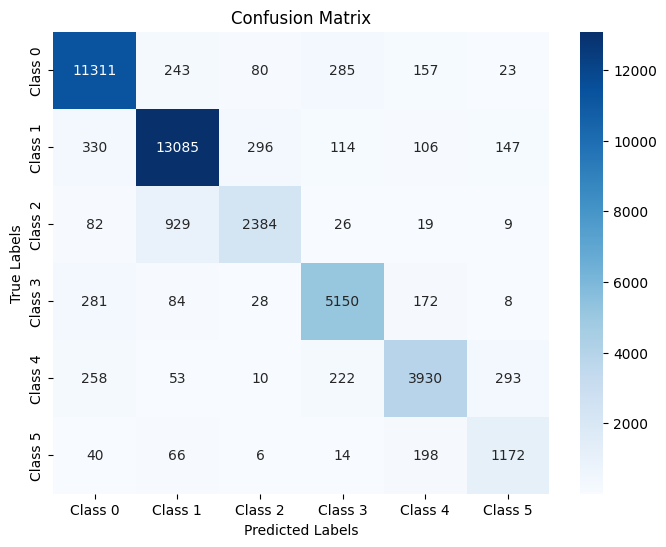


Model saved as 'tfidf_gru_model_3.h5'



In [ ]:
tfidf_gru_model_3, tfidf_gru_metrics_3, tfidf_gru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_3.save('tfidf_gru_model_3.h5')
print("\nModel saved as 'tfidf_gru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 90s 4ms/step - accuracy: 0.8327 - loss: 0.4713 - val_accuracy: 0.8795 - val_loss: 0.3035
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.8870 - loss: 0.2954 - val_accuracy: 0.8839 - val_loss: 0.3198
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.8967 - loss: 0.2678 - val_accuracy: 0.8795 - val_loss: 0.3957
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9008 - loss: 0.2608 - val_accuracy: 0.8828 - val_loss: 0.4659
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.9029 - loss: 0.2524 - val_accuracy: 0.8790 - val_loss: 0.5487
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.9051 - loss: 0.2502 - val_accuracy: 0.8759 - val_loss: 0.5897
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



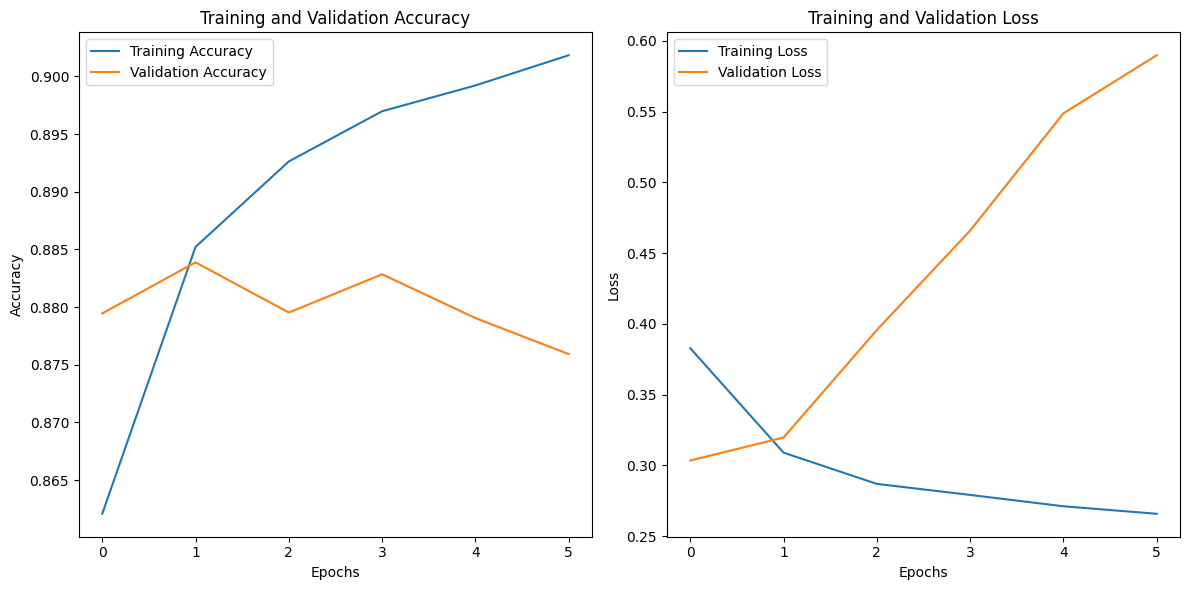

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     12099
           1       0.93      0.88      0.90     14078
           2       0.72      0.88      0.79      3449
           3       0.93      0.84      0.88      5723
           4       0.81      0.89      0.85      4766
           5       0.75      0.75      0.75      1496

    accuracy                           0.88     41611
   macro avg       0.84      0.86      0.85     41611
weighted avg       0.89      0.88      0.88     41611


Metrics:

Train Loss: 0.26586443185806274
Val Loss: 0.5897374153137207
Test Loss: 0.30065834522247314
AUC: 0.9877224549014912
Accuracy: 0.8823868632316589
Precision: 0.8874373468704146
Recall: 0.8823868688567926
F1-Score: 0.8835348248021542

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


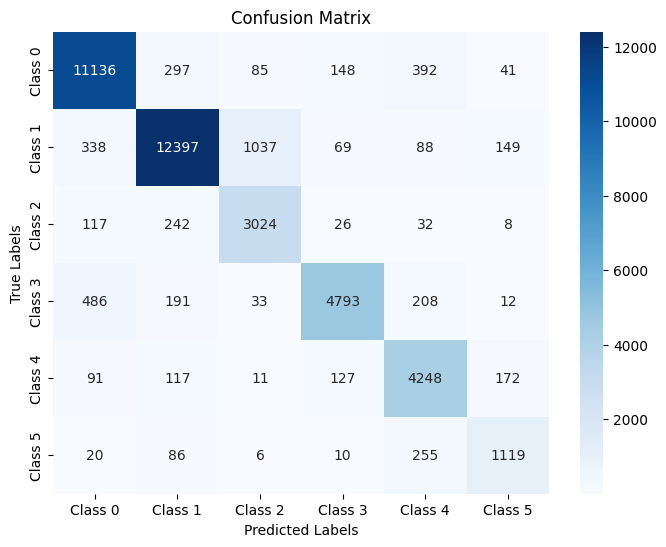


Model saved as 'tfidf_gru_model_4.h5'



In [ ]:
tfidf_gru_model_4, tfidf_gru_metrics_4, tfidf_gru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_4.save('tfidf_gru_model_4.h5')
print("\nModel saved as 'tfidf_gru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - accuracy: 0.8300 - loss: 0.4486 - val_accuracy: 0.8860 - val_loss: 0.2476
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.8938 - loss: 0.2370 - val_accuracy: 0.8917 - val_loss: 0.2356
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9006 - loss: 0.2147 - val_accuracy: 0.8941 - val_loss: 0.2329
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9043 - loss: 0.2003 - val_accuracy: 0.8923 - val_loss: 0.2404
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9090 - loss: 0.1856 - val_accuracy: 0.8886 - val_loss: 0.2480
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9124 - loss: 0.1784 - val_accuracy: 0.8908 - val_loss: 0.2568
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9165 - loss: 0.1654 - val_accuracy: 0.8880 - val_loss: 0.2700
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - ac

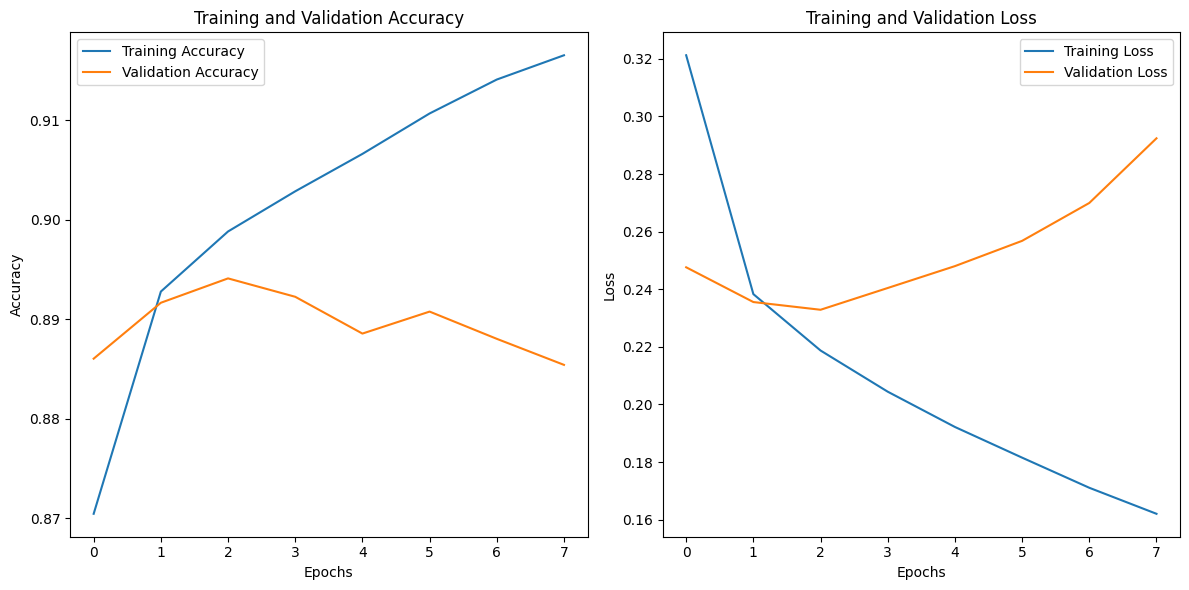

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     12099
           1       0.89      0.94      0.92     14078
           2       0.89      0.65      0.75      3449
           3       0.89      0.90      0.89      5723
           4       0.83      0.88      0.85      4766
           5       0.89      0.60      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.88      0.82      0.84     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.1620585024356842
Val Loss: 0.2923940420150757
Test Loss: 0.23732228577136993
AUC: 0.9922547582730162
Accuracy: 0.8918314576148987
Precision: 0.8920031958400176
Recall: 0.8918314868664535
F1-Score: 0.8890867130788315

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


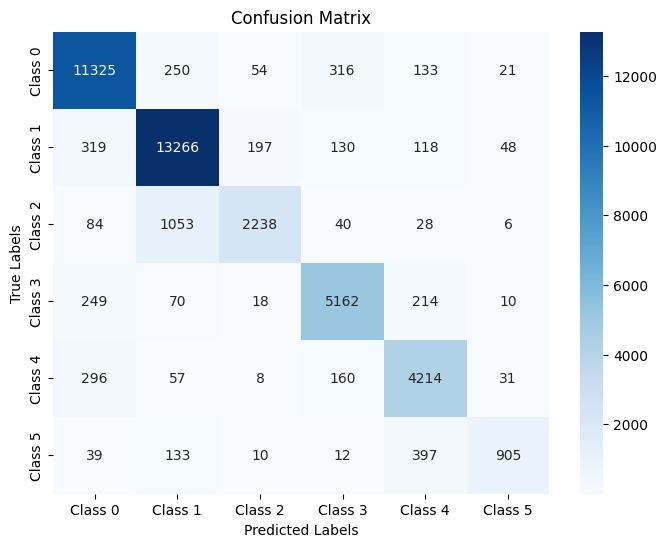


Model saved as 'tfidf_gru_model_5.h5'



In [ ]:
tfidf_gru_model_5, tfidf_gru_metrics_5, tfidf_gru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_5.save('tfidf_gru_model_5.h5')
print("\nModel saved as 'tfidf_gru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.6707 - loss: 0.8964 - val_accuracy: 0.8868 - val_loss: 0.2736
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.8941 - loss: 0.2718 - val_accuracy: 0.8893 - val_loss: 0.2494
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8991 - loss: 0.2425 - val_accuracy: 0.8880 - val_loss: 0.2375
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - accuracy: 0.9003 - loss: 0.2253 - val_accuracy: 0.8879 - val_loss: 0.2340
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9026 - loss: 0.2135 - val_accuracy: 0.8891 - val_loss: 0.2316
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9024 - loss: 0.2089 - val_accuracy: 0.8897 - val_loss: 0.2327
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.9046 - loss: 0.2043 - val_accuracy: 0.8888 - val_loss: 0.2330
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - ac

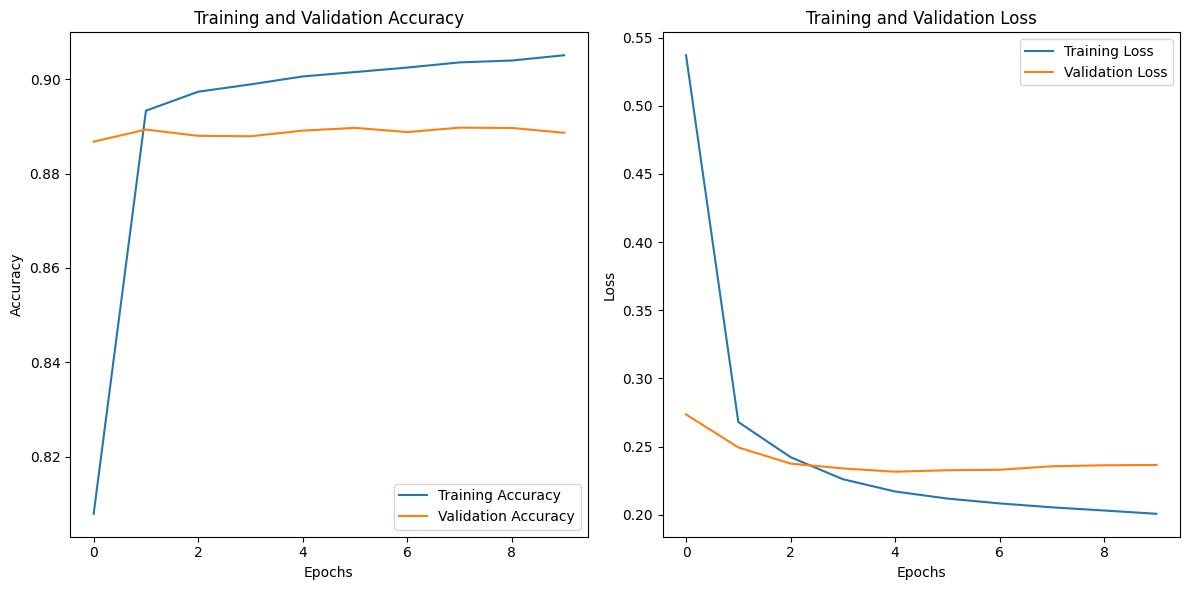

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12099
           1       0.91      0.92      0.91     14078
           2       0.80      0.75      0.77      3449
           3       0.87      0.91      0.89      5723
           4       0.85      0.83      0.84      4766
           5       0.73      0.74      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.200717031955719
Val Loss: 0.236520454287529
Test Loss: 0.23323974013328552
AUC: 0.9922935007763298
Accuracy: 0.888298749923706
Precision: 0.8878946556631826
Recall: 0.8882987671529163
F1-Score: 0.8879215845772573

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


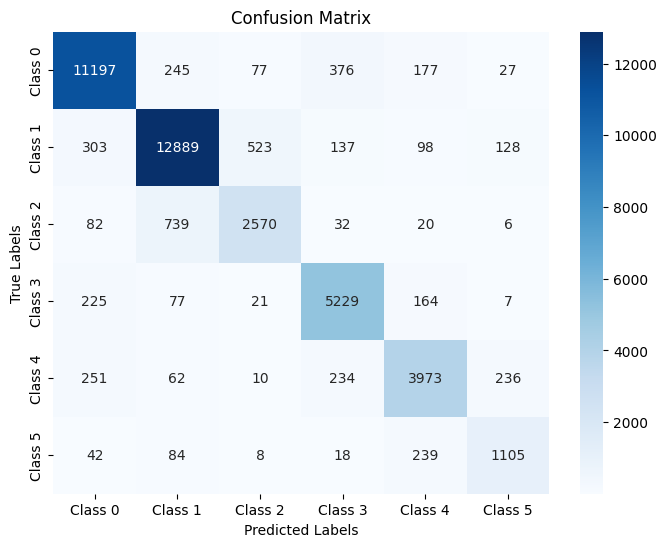


Model saved as 'tfidf_gru_model_6.h5'



In [ ]:
tfidf_gru_model_6, tfidf_gru_metrics_6, tfidf_gru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_6.save('tfidf_gru_model_6.h5')
print("\nModel saved as 'tfidf_gru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.8345 - loss: 0.4538 - val_accuracy: 0.8827 - val_loss: 0.2835
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8919 - loss: 0.2601 - val_accuracy: 0.8855 - val_loss: 0.2980
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9073 - loss: 0.2116 - val_accuracy: 0.8813 - val_loss: 0.3509
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9150 - loss: 0.1877 - val_accuracy: 0.8766 - val_loss: 0.4318
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9195 - loss: 0.1781 - val_accuracy: 0.8768 - val_loss: 0.5261
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9231 - loss: 0.1729 - val_accuracy: 0.8751 - val_loss: 0.6352
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



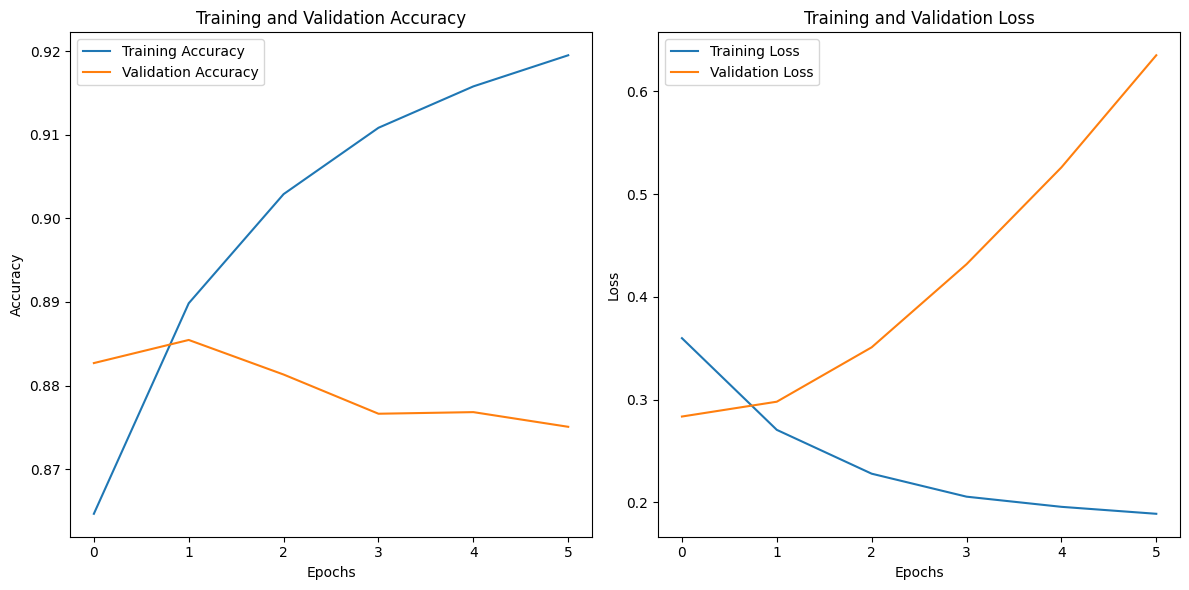

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     12099
           1       0.90      0.91      0.91     14078
           2       0.76      0.79      0.77      3449
           3       0.91      0.85      0.88      5723
           4       0.79      0.92      0.85      4766
           5       0.84      0.64      0.73      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.84      0.84     41611
weighted avg       0.89      0.88      0.88     41611


Metrics:

Train Loss: 0.18885880708694458
Val Loss: 0.6351945996284485
Test Loss: 0.28556522727012634
AUC: 0.9893683539996756
Accuracy: 0.8838528394699097
Precision: 0.8860923511575894
Recall: 0.8838528273773761
F1-Score: 0.8837690753527836

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


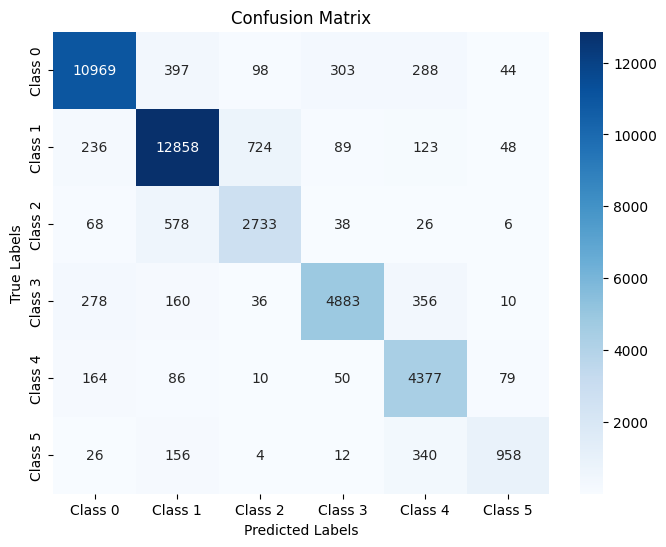


Model saved as 'tfidf_gru_model_7.h5'



In [ ]:
tfidf_gru_model_7, tfidf_gru_metrics_7, tfidf_gru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_7.save('tfidf_gru_model_7.h5')
print("\nModel saved as 'tfidf_gru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8150 - loss: 0.4892 - val_accuracy: 0.8881 - val_loss: 0.2434
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.8935 - loss: 0.2354 - val_accuracy: 0.8900 - val_loss: 0.2384
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8987 - loss: 0.2146 - val_accuracy: 0.8902 - val_loss: 0.2351
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9041 - loss: 0.1990 - val_accuracy: 0.8921 - val_loss: 0.2373
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9078 - loss: 0.1864 - val_accuracy: 0.8916 - val_loss: 0.2416
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9103 - loss: 0.1775 - val_accuracy: 0.8861 - val_loss: 0.2580
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9148 - loss: 0.1666 - val_accuracy: 0.8865 - val_loss: 0.2665
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - ac

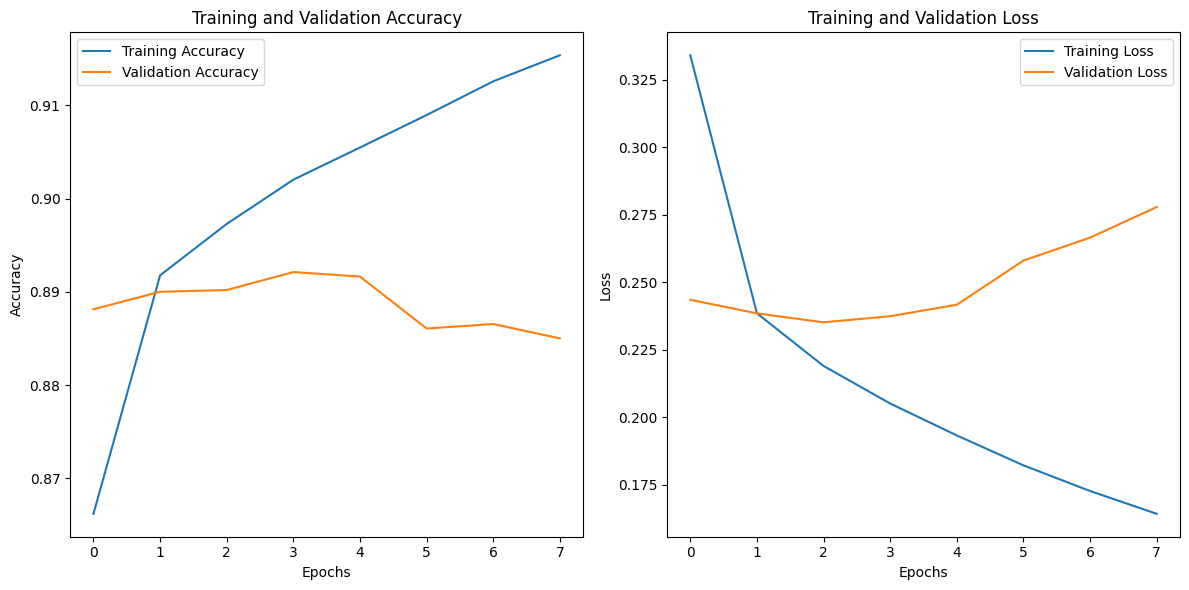

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     12099
           1       0.92      0.91      0.92     14078
           2       0.78      0.79      0.79      3449
           3       0.91      0.88      0.89      5723
           4       0.80      0.94      0.86      4766
           5       0.80      0.64      0.71      1496

    accuracy                           0.89     41611
   macro avg       0.86      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.16416186094284058
Val Loss: 0.2777942717075348
Test Loss: 0.2372736781835556
AUC: 0.99232492346454
Accuracy: 0.8904376029968262
Precision: 0.8924239383837146
Recall: 0.8904376246665545
F1-Score: 0.8903727152796994

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


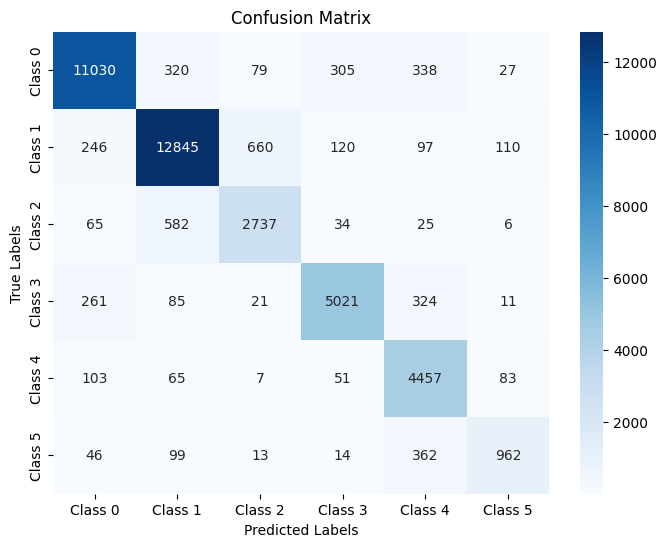


Model saved as 'tfidf_gru_model_8.h5'



In [ ]:
tfidf_gru_model_8, tfidf_gru_metrics_8, tfidf_gru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_8.save('tfidf_gru_model_8.h5')
print("\nModel saved as 'tfidf_gru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.6282 - loss: 1.0260 - val_accuracy: 0.8846 - val_loss: 0.2900
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8913 - loss: 0.2885 - val_accuracy: 0.8880 - val_loss: 0.2606
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8977 - loss: 0.2582 - val_accuracy: 0.8869 - val_loss: 0.2505
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9006 - loss: 0.2391 - val_accuracy: 0.8880 - val_loss: 0.2426
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9020 - loss: 0.2271 - val_accuracy: 0.8873 - val_loss: 0.2383
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9025 - loss: 0.2166 - val_accuracy: 0.8866 - val_loss: 0.2352
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9041 - loss: 0.2110 - val_accuracy: 0.8881 - val_loss: 0.2340
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - ac

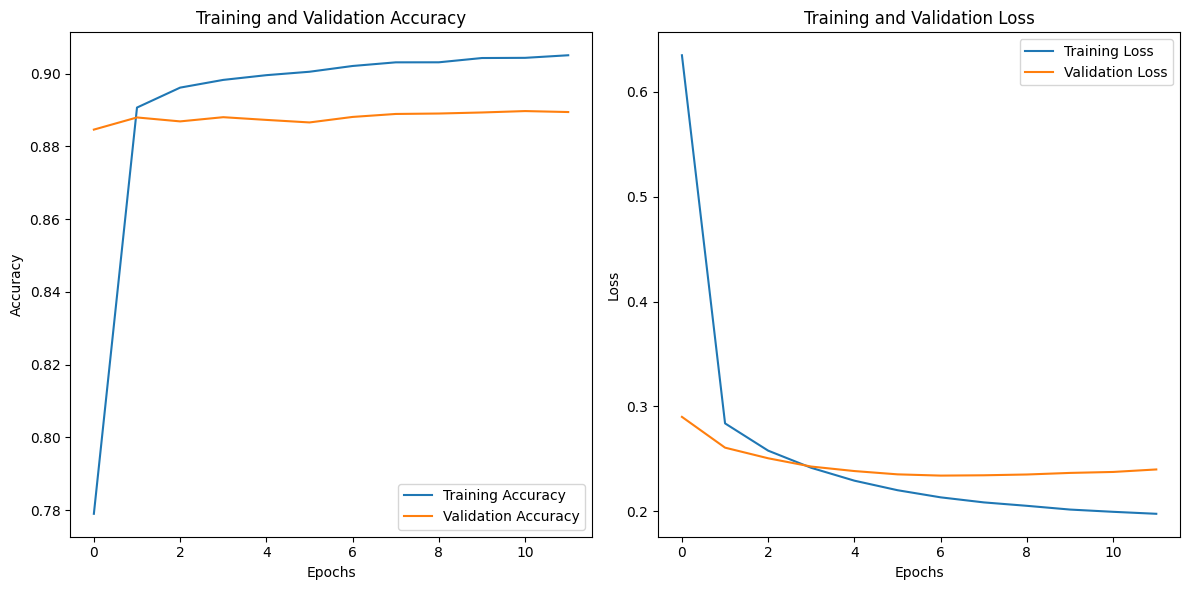

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.92      0.90      0.91     14078
           2       0.76      0.80      0.78      3449
           3       0.89      0.89      0.89      5723
           4       0.84      0.85      0.84      4766
           5       0.70      0.77      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.84      0.86      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19753974676132202
Val Loss: 0.23984992504119873
Test Loss: 0.23572169244289398
AUC: 0.9921332076620993
Accuracy: 0.887481689453125
Precision: 0.88904926274569
Recall: 0.8874816755184927
F1-Score: 0.8881159962556134

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


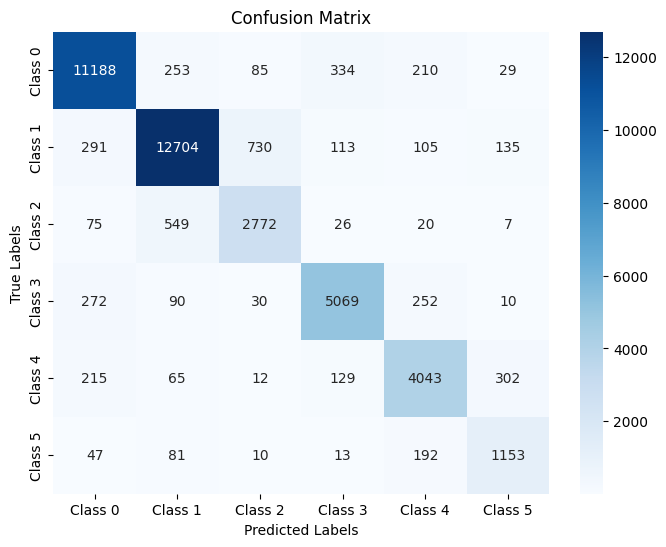


Model saved as 'tfidf_gru_model_9.h5'



In [ ]:
tfidf_gru_model_9, tfidf_gru_metrics_9, tfidf_gru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="gru"
)

tfidf_gru_model_9.save('tfidf_gru_model_9.h5')
print("\nModel saved as 'tfidf_gru_model_9.h5'\n")

## Bi-GRU

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 214s 5ms/step - accuracy: 0.8280 - loss: 0.5013 - val_accuracy: 0.8758 - val_loss: 0.3605
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.8864 - loss: 0.3465 - val_accuracy: 0.8751 - val_loss: 0.4285
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 207s 5ms/step - accuracy: 0.8905 - loss: 0.3339 - val_accuracy: 0.8770 - val_loss: 0.5533
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 207s 5ms/step - accuracy: 0.8934 - loss: 0.3385 - val_accuracy: 0.8767 - val_loss: 0.6147
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 215s 5ms/step - accuracy: 0.8944 - loss: 0.3219 - val_accuracy: 0.8795 - val_loss: 0.6849
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 229s 6ms/step - accuracy: 0.8964 - loss: 0.3136 - val_accuracy: 0.8782 - val_loss: 0.8668
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



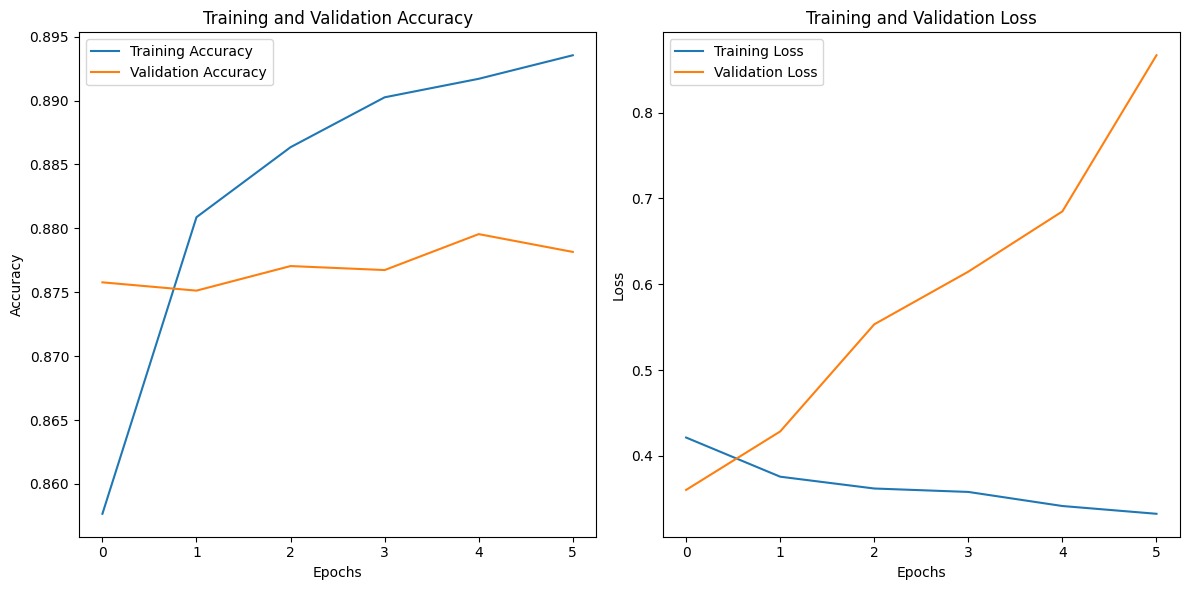

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     12099
           1       0.95      0.85      0.90     14078
           2       0.66      0.92      0.77      3449
           3       0.86      0.91      0.88      5723
           4       0.85      0.83      0.84      4766
           5       0.80      0.64      0.71      1496

    accuracy                           0.88     41611
   macro avg       0.84      0.85      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.332633376121521
Val Loss: 0.8667547106742859
Test Loss: 0.3590099513530731
AUC: 0.984555950814106
Accuracy: 0.8750090003013611
Precision: 0.8841916284877226
Recall: 0.8750090120400855
F1-Score: 0.8763495083124382

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


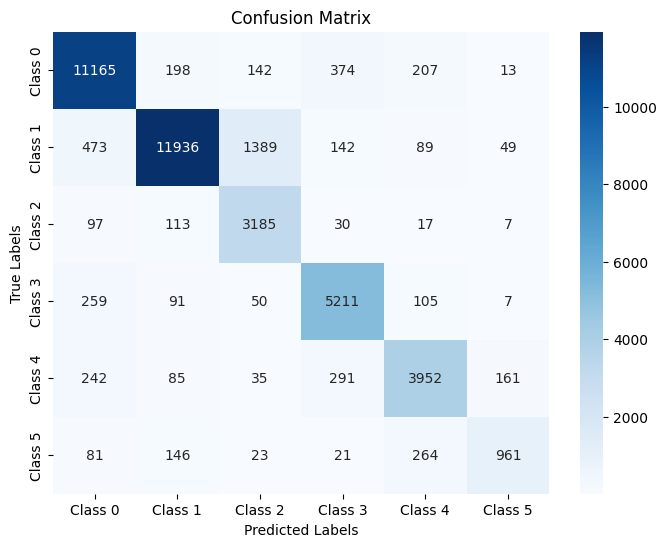


Model saved as 'tfidf_bigru_model_1.h5'



In [ ]:
tfidf_bigru_model_1, tfidf_bigru_metrics_1, tfidf_bigru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_1.save('tfidf_bigru_model_1.h5')
print("\nModel saved as 'tfidf_bigru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 265s 6ms/step - accuracy: 0.8397 - loss: 0.4183 - val_accuracy: 0.8892 - val_loss: 0.2459
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 253s 6ms/step - accuracy: 0.8949 - loss: 0.2369 - val_accuracy: 0.8907 - val_loss: 0.2382
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9023 - loss: 0.2120 - val_accuracy: 0.8904 - val_loss: 0.2396
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 231s 6ms/step - accuracy: 0.9064 - loss: 0.2004 - val_accuracy: 0.8908 - val_loss: 0.2427
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 231s 6ms/step - accuracy: 0.9096 - loss: 0.1877 - val_accuracy: 0.8909 - val_loss: 0.2555
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9144 - loss: 0.1744 - val_accuracy: 0.8891 - val_loss: 0.2731
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9181 - loss: 0.1635 - val_accuracy: 0.8882 - val_loss: 0.2874
Epoch 7: early stopping
Restoring model weights from th

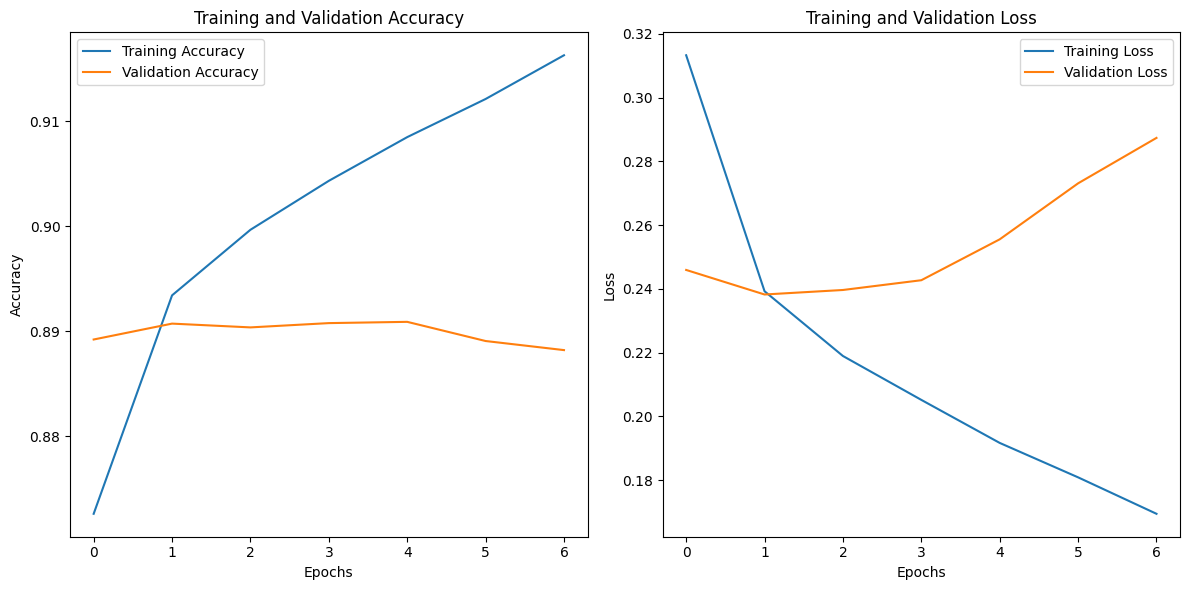

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     12099
           1       0.93      0.90      0.91     14078
           2       0.76      0.83      0.79      3449
           3       0.91      0.87      0.89      5723
           4       0.89      0.82      0.85      4766
           5       0.73      0.82      0.78      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.86      0.86     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.16940411925315857
Val Loss: 0.2873793840408325
Test Loss: 0.23987682163715363
AUC: 0.9921767205252792
Accuracy: 0.8910865187644958
Precision: 0.8929995895909533
Recall: 0.8910864915527145
F1-Score: 0.8913927823789838

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


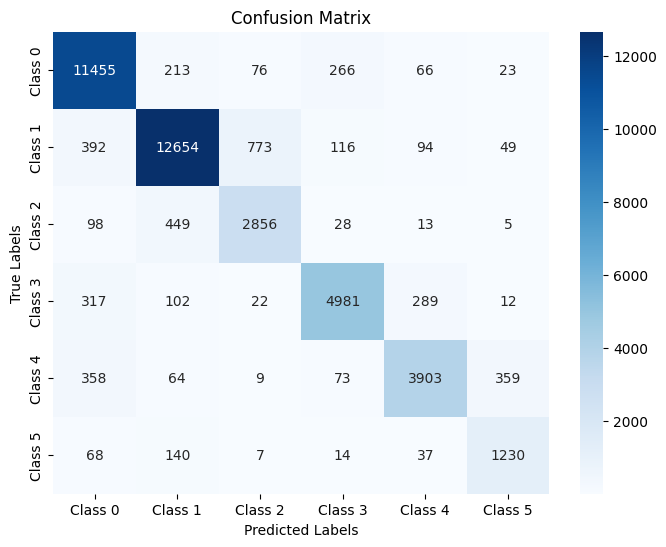


Model saved as 'tfidf_bigru_model_2.h5'



In [ ]:
tfidf_bigru_model_2, tfidf_bigru_metrics_2, tfidf_bigru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_2.save('tfidf_bigru_model_2.h5')
print("\nModel saved as 'tfidf_bigru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 236s 6ms/step - accuracy: 0.7476 - loss: 0.7044 - val_accuracy: 0.8872 - val_loss: 0.2583
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 231s 6ms/step - accuracy: 0.8963 - loss: 0.2512 - val_accuracy: 0.8891 - val_loss: 0.2358
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 230s 6ms/step - accuracy: 0.9004 - loss: 0.2239 - val_accuracy: 0.8900 - val_loss: 0.2305
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 230s 6ms/step - accuracy: 0.9010 - loss: 0.2160 - val_accuracy: 0.8921 - val_loss: 0.2292
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9032 - loss: 0.2077 - val_accuracy: 0.8900 - val_loss: 0.2291
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 234s 6ms/step - accuracy: 0.9042 - loss: 0.2070 - val_accuracy: 0.8913 - val_loss: 0.2307
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/step - accuracy: 0.9055 - loss: 0.2026 - val_accuracy: 0.8913 - val_loss: 0.2306
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 234s 6ms/s

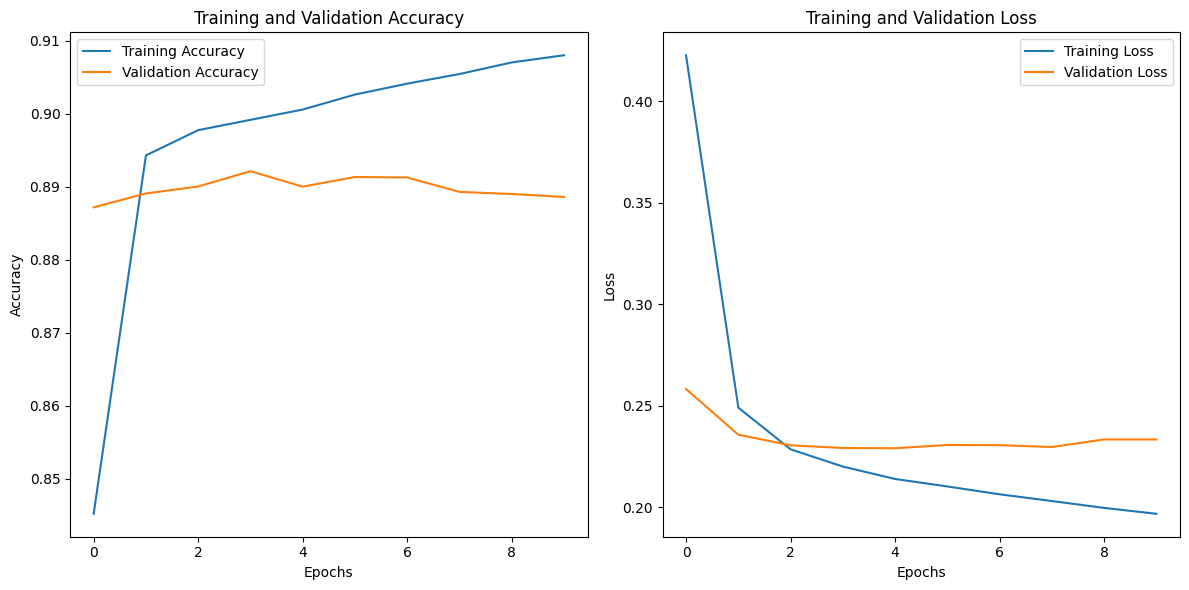

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12099
           1       0.92      0.91      0.92     14078
           2       0.78      0.79      0.79      3449
           3       0.88      0.91      0.89      5723
           4       0.86      0.82      0.84      4766
           5       0.71      0.75      0.73      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19680476188659668
Val Loss: 0.23343966901302338
Test Loss: 0.23120252788066864
AUC: 0.9924545718920644
Accuracy: 0.8901011943817139
Precision: 0.8905437434234615
Recall: 0.8901011751700272
F1-Score: 0.890207195457616

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


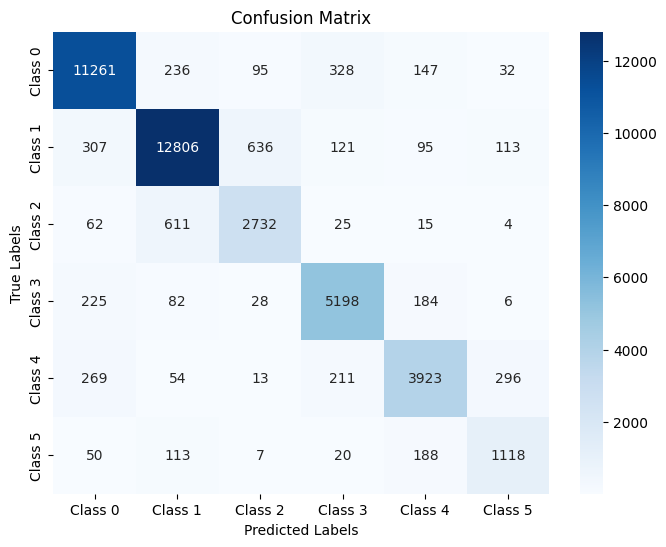


Model saved as 'tfidf_bigru_model_3.h5'



In [ ]:
tfidf_bigru_model_3, tfidf_bigru_metrics_3, tfidf_bigru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_3.save('tfidf_bigru_model_3.h5')
print("\nModel saved as 'tfidf_bigru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 122s 6ms/step - accuracy: 0.8329 - loss: 0.4719 - val_accuracy: 0.8804 - val_loss: 0.2980
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8936 - loss: 0.2807 - val_accuracy: 0.8828 - val_loss: 0.3415
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9055 - loss: 0.2415 - val_accuracy: 0.8799 - val_loss: 0.4759
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9118 - loss: 0.2338 - val_accuracy: 0.8723 - val_loss: 0.6381
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9132 - loss: 0.2349 - val_accuracy: 0.8698 - val_loss: 0.8139
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.9149 - loss: 0.2358 - val_accuracy: 0.8730 - val_loss: 0.9409
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



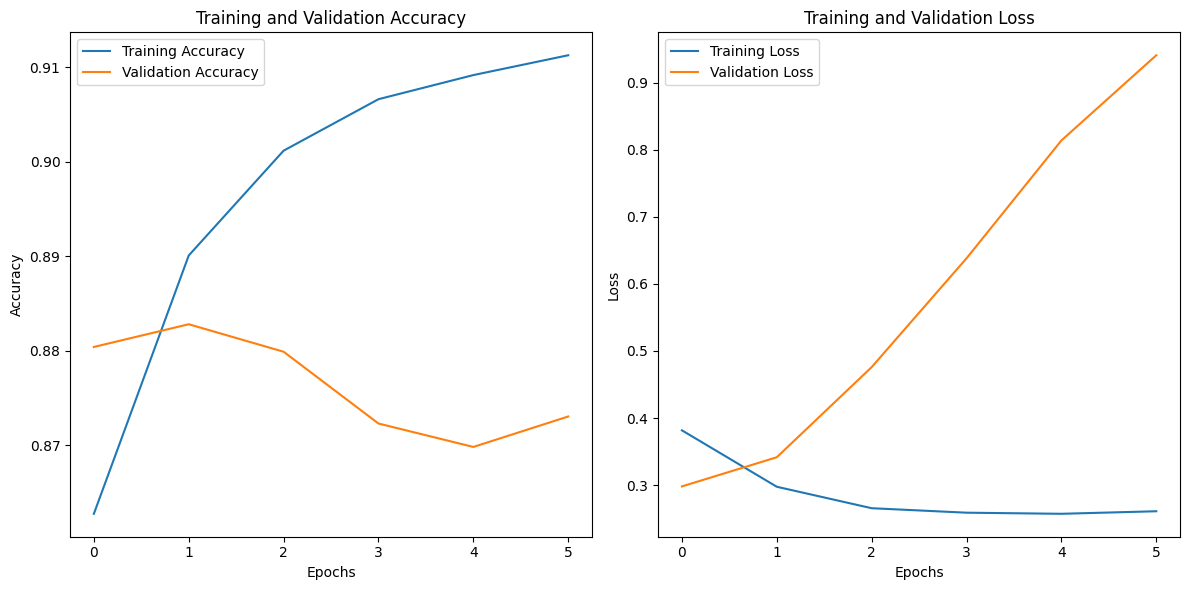

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     12099
           1       0.88      0.94      0.91     14078
           2       0.90      0.61      0.73      3449
           3       0.93      0.82      0.87      5723
           4       0.83      0.87      0.85      4766
           5       0.74      0.81      0.77      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.83      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.2609555125236511
Val Loss: 0.9408895373344421
Test Loss: 0.29432588815689087
AUC: 0.9883114520356351
Accuracy: 0.882723331451416
Precision: 0.8848085251365795
Recall: 0.8827233183533201
F1-Score: 0.880416623248501

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


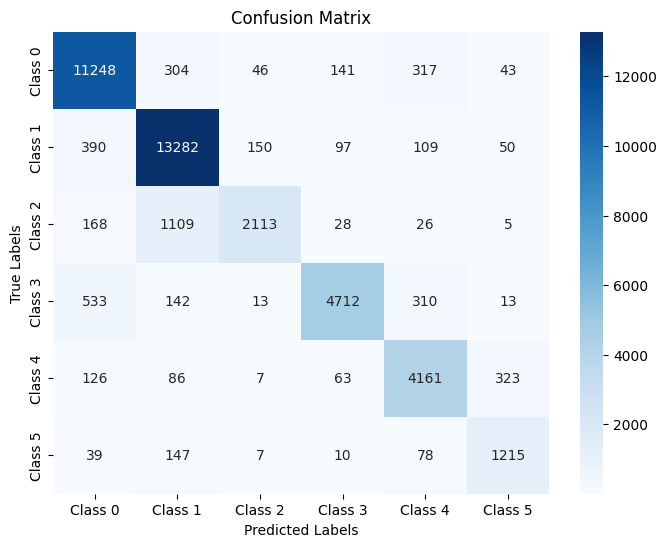


Model saved as 'tfidf_bigru_model_4.h5'



In [ ]:
tfidf_bigru_model_4, tfidf_bigru_metrics_4, tfidf_bigru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_4.save('tfidf_bigru_model_4.h5')
print("\nModel saved as 'tfidf_bigru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.8345 - loss: 0.4391 - val_accuracy: 0.8872 - val_loss: 0.2446
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8936 - loss: 0.2372 - val_accuracy: 0.8920 - val_loss: 0.2375
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9001 - loss: 0.2144 - val_accuracy: 0.8926 - val_loss: 0.2364
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9049 - loss: 0.1967 - val_accuracy: 0.8887 - val_loss: 0.2429
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9098 - loss: 0.1847 - val_accuracy: 0.8910 - val_loss: 0.2517
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9144 - loss: 0.1708 - val_accuracy: 0.8910 - val_loss: 0.2597
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9168 - loss: 0.1616 - val_accuracy: 0.8864 - val_loss: 0.2844
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/s

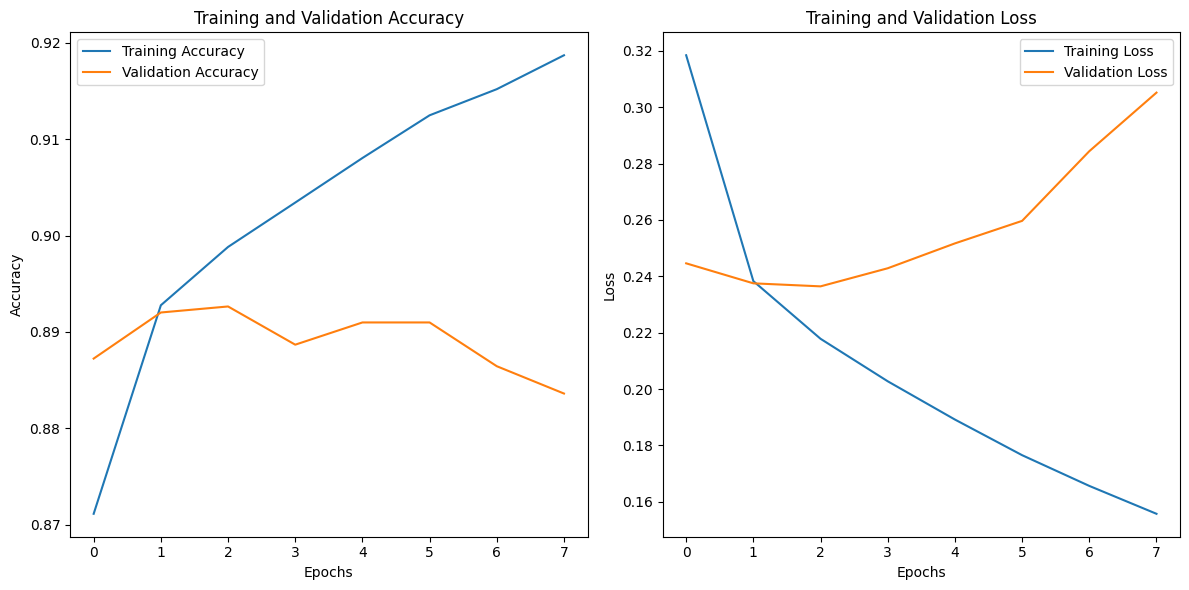

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.93     12099
           1       0.89      0.95      0.92     14078
           2       0.90      0.65      0.75      3449
           3       0.92      0.87      0.89      5723
           4       0.84      0.86      0.85      4766
           5       0.85      0.62      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.88      0.82      0.84     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.1557588279247284
Val Loss: 0.3051636517047882
Test Loss: 0.24055610597133636
AUC: 0.9923057597225813
Accuracy: 0.8906539082527161
Precision: 0.8905570602227872
Recall: 0.8906539136286078
F1-Score: 0.8876537669331576

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


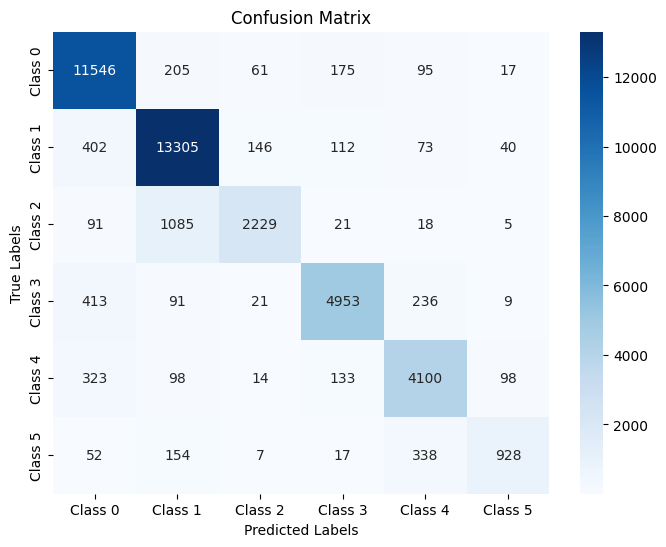


Model saved as 'tfidf_bigru_model_5.h5'



In [ ]:
tfidf_bigru_model_5, tfidf_bigru_metrics_5, tfidf_bigru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_5.save('tfidf_bigru_model_5.h5')
print("\nModel saved as 'tfidf_bigru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.7142 - loss: 0.7999 - val_accuracy: 0.8889 - val_loss: 0.2621
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8952 - loss: 0.2605 - val_accuracy: 0.8886 - val_loss: 0.2425
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8992 - loss: 0.2318 - val_accuracy: 0.8894 - val_loss: 0.2327
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9007 - loss: 0.2162 - val_accuracy: 0.8896 - val_loss: 0.2312
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9026 - loss: 0.2087 - val_accuracy: 0.8894 - val_loss: 0.2313
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.9032 - loss: 0.2058 - val_accuracy: 0.8885 - val_loss: 0.2316
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9048 - loss: 0.2017 - val_accuracy: 0.8886 - val_loss: 0.2327
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/s

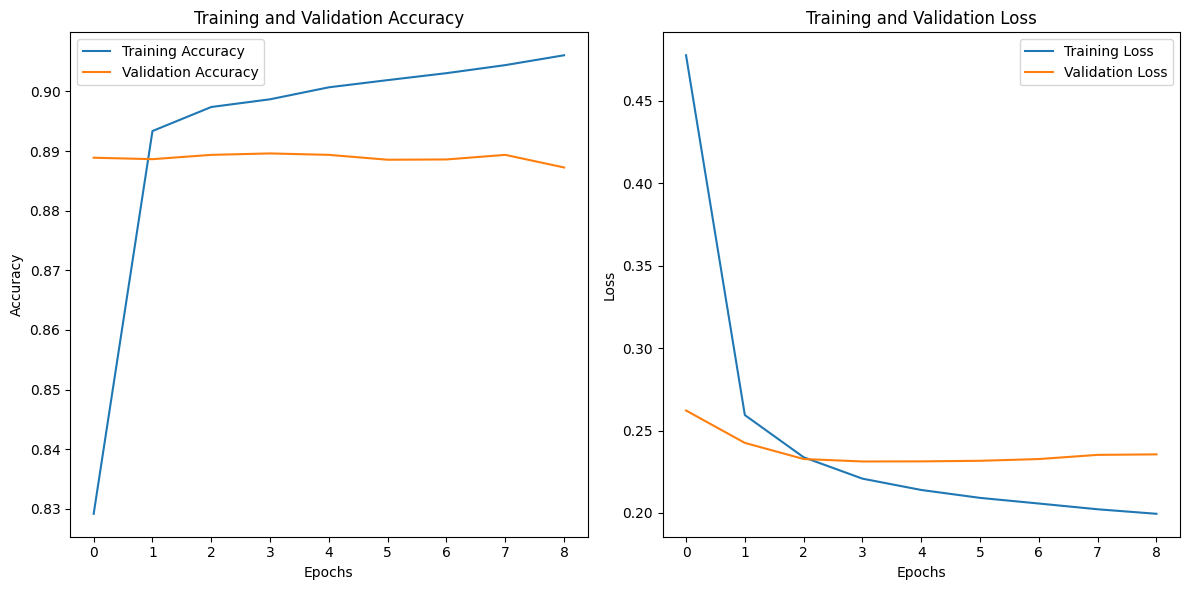

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.92      0.91      0.91     14078
           2       0.79      0.78      0.78      3449
           3       0.90      0.88      0.89      5723
           4       0.83      0.86      0.85      4766
           5       0.70      0.78      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.84      0.86      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19948437809944153
Val Loss: 0.2355211079120636
Test Loss: 0.23300482332706451
AUC: 0.9922976742620112
Accuracy: 0.8892600536346436
Precision: 0.8903538740614725
Recall: 0.8892600514287088
F1-Score: 0.8896669798355514

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


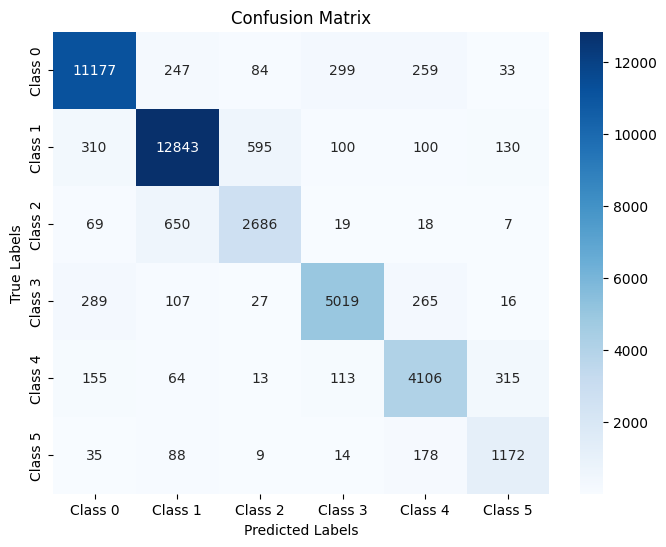


Model saved as 'tfidf_bigru_model_6.h5'



In [ ]:
tfidf_bigru_model_6, tfidf_bigru_metrics_6, tfidf_bigru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_6.save('tfidf_bigru_model_6.h5')
print("\nModel saved as 'tfidf_bigru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.8343 - loss: 0.4525 - val_accuracy: 0.8853 - val_loss: 0.2803
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.8934 - loss: 0.2535 - val_accuracy: 0.8875 - val_loss: 0.2922
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9113 - loss: 0.1983 - val_accuracy: 0.8828 - val_loss: 0.3646
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9203 - loss: 0.1723 - val_accuracy: 0.8788 - val_loss: 0.4694
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9253 - loss: 0.1614 - val_accuracy: 0.8743 - val_loss: 0.6115
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9285 - loss: 0.1598 - val_accuracy: 0.8747 - val_loss: 0.7259
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



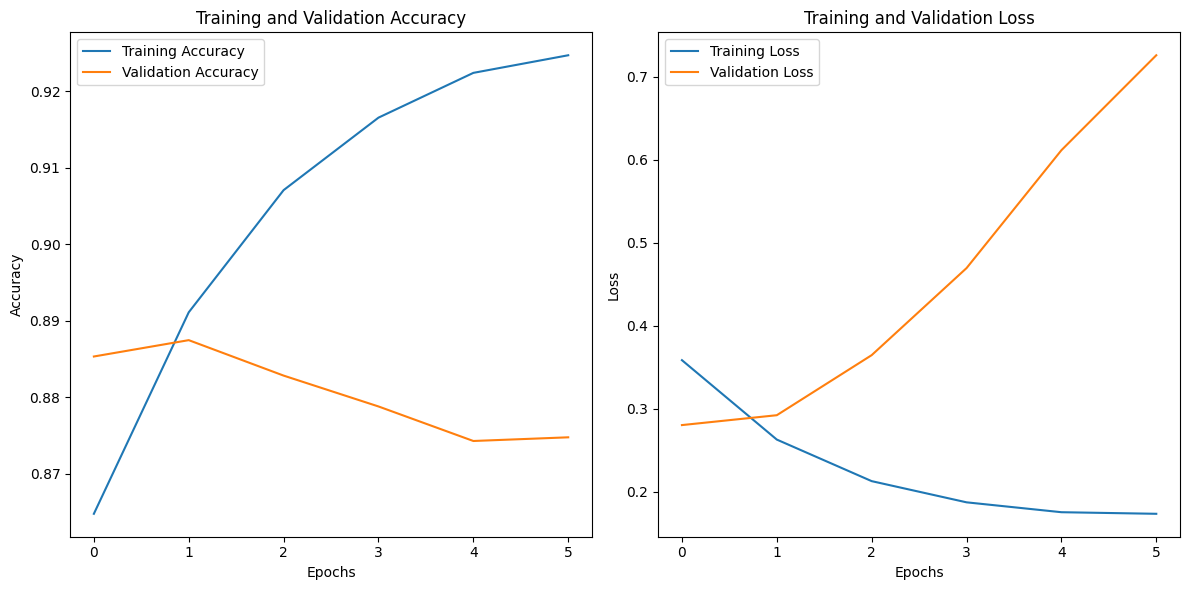

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     12099
           1       0.88      0.95      0.91     14078
           2       0.93      0.59      0.72      3449
           3       0.87      0.89      0.88      5723
           4       0.87      0.81      0.84      4766
           5       0.70      0.89      0.79      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.84      0.84     41611
weighted avg       0.89      0.88      0.88     41611


Metrics:

Train Loss: 0.17343930900096893
Val Loss: 0.72587651014328
Test Loss: 0.286868691444397
AUC: 0.9892462437252799
Accuracy: 0.8831799030303955
Precision: 0.8864042660982475
Recall: 0.8831799283843215
F1-Score: 0.8807554189245651

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


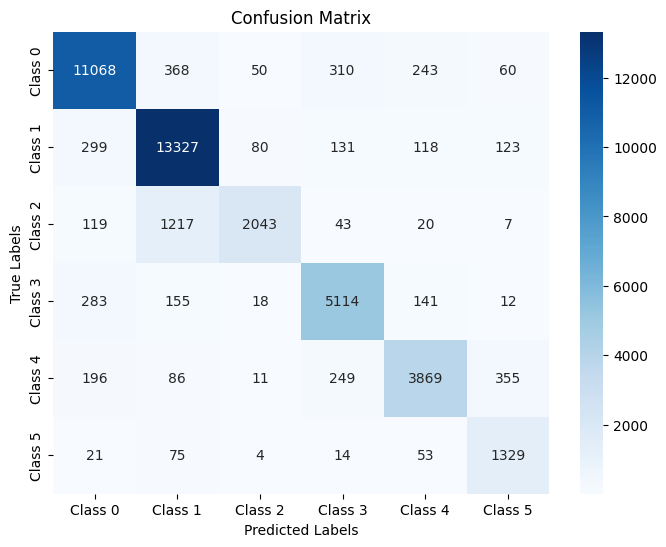


Model saved as 'tfidf_bigru_model_7.h5'



In [ ]:
tfidf_bigru_model_7, tfidf_bigru_metrics_7, tfidf_bigru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_7.save('tfidf_bigru_model_7.h5')
print("\nModel saved as 'tfidf_bigru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.8246 - loss: 0.4661 - val_accuracy: 0.8875 - val_loss: 0.2454
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.8930 - loss: 0.2361 - val_accuracy: 0.8909 - val_loss: 0.2389
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9004 - loss: 0.2130 - val_accuracy: 0.8907 - val_loss: 0.2392
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9043 - loss: 0.1990 - val_accuracy: 0.8911 - val_loss: 0.2391
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9087 - loss: 0.1855 - val_accuracy: 0.8904 - val_loss: 0.2475
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9130 - loss: 0.1736 - val_accuracy: 0.8891 - val_loss: 0.2543
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9157 - loss: 0.1633 - val_accuracy: 0.8886 - val_loss: 0.2704
Epoch 7: early stopping
Restoring model weights from the end o

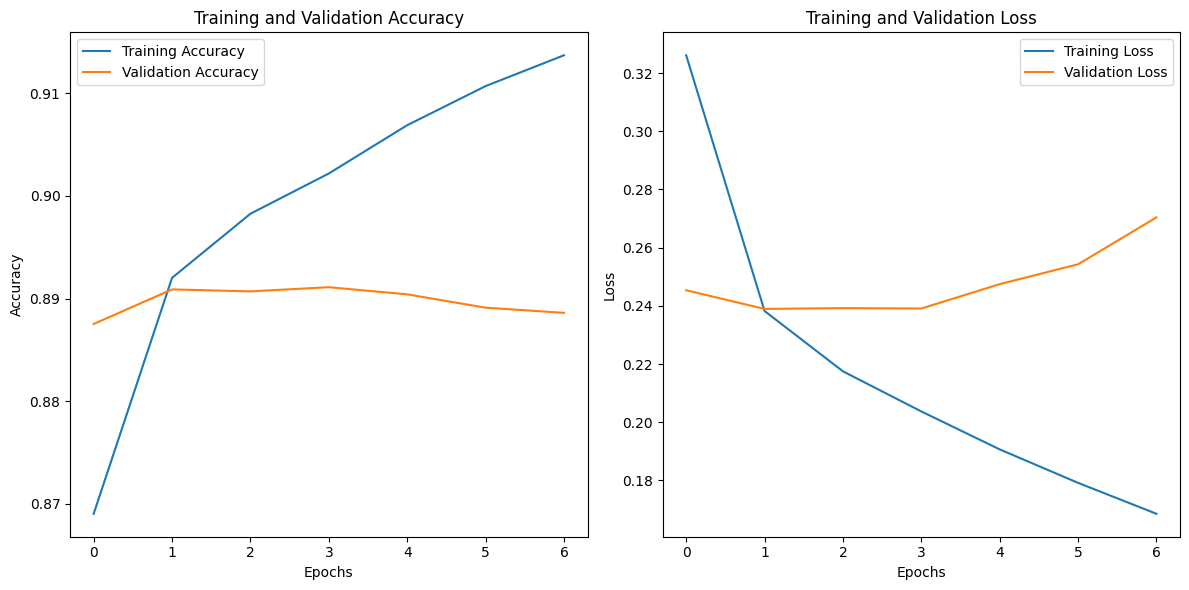

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.89      0.94      0.92     14078
           2       0.84      0.71      0.77      3449
           3       0.88      0.92      0.90      5723
           4       0.90      0.79      0.84      4766
           5       0.73      0.81      0.77      1496

    accuracy                           0.89     41611
   macro avg       0.86      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.16855022311210632
Val Loss: 0.2704055905342102
Test Loss: 0.2390119731426239
AUC: 0.9922841866341563
Accuracy: 0.8908221125602722
Precision: 0.8911389289113711
Recall: 0.8908221383768715
F1-Score: 0.8897764609292751

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


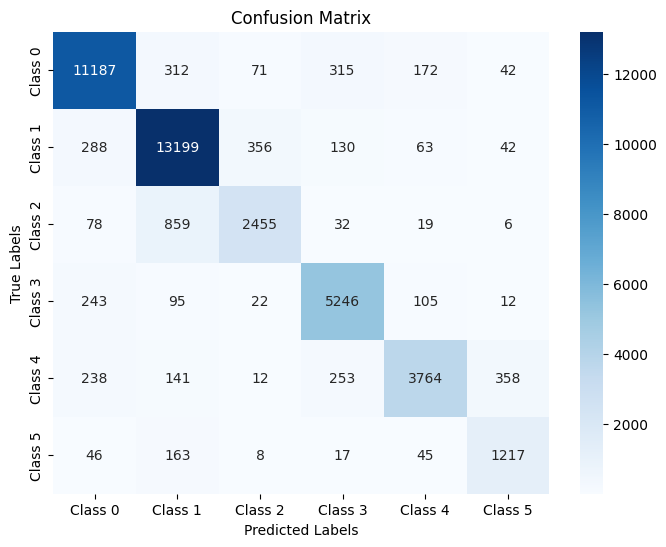


Model saved as 'tfidf_bigru_model_8.h5'



In [ ]:
tfidf_bigru_model_8, tfidf_bigru_metrics_8, tfidf_bigru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_8.save('tfidf_bigru_model_8.h5')
print("\nModel saved as 'tfidf_bigru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.6628 - loss: 0.9317 - val_accuracy: 0.8870 - val_loss: 0.2689
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.8927 - loss: 0.2699 - val_accuracy: 0.8878 - val_loss: 0.2492
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.8987 - loss: 0.2403 - val_accuracy: 0.8883 - val_loss: 0.2390
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9014 - loss: 0.2229 - val_accuracy: 0.8877 - val_loss: 0.2330
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9029 - loss: 0.2118 - val_accuracy: 0.8883 - val_loss: 0.2325
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9037 - loss: 0.2039 - val_accuracy: 0.8888 - val_loss: 0.2325
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9049 - loss: 0.2000 - val_accuracy: 0.8895 - val_loss: 0.2344
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - ac

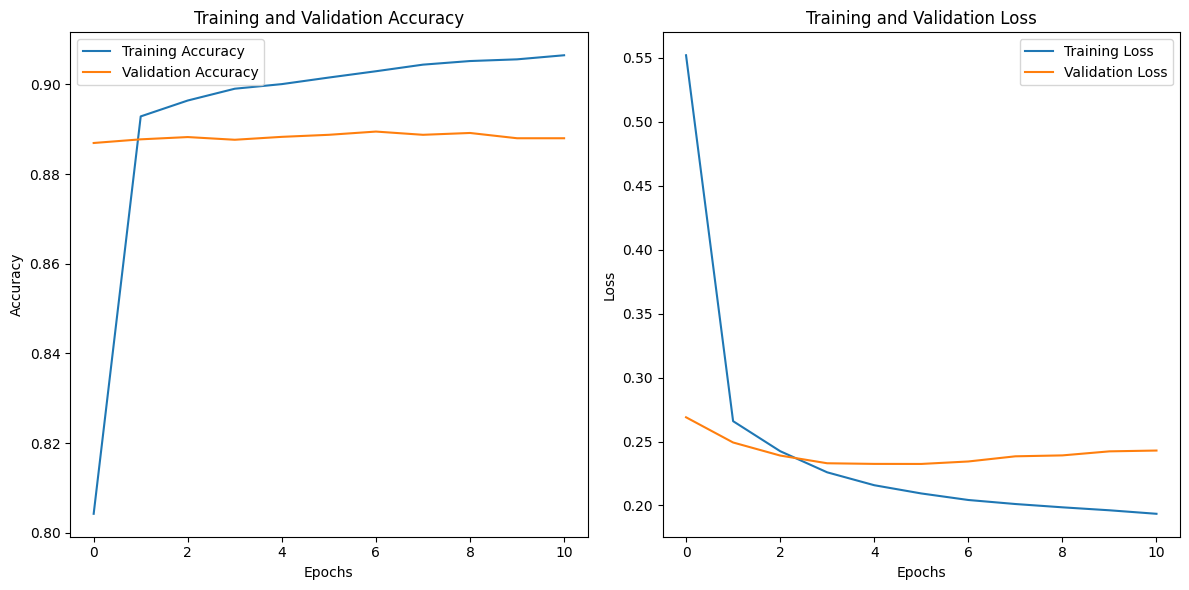

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12099
           1       0.92      0.91      0.91     14078
           2       0.77      0.79      0.78      3449
           3       0.90      0.89      0.89      5723
           4       0.83      0.85      0.84      4766
           5       0.72      0.74      0.73      1496

    accuracy                           0.89     41611
   macro avg       0.84      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19346964359283447
Val Loss: 0.24293141067028046
Test Loss: 0.23288580775260925
AUC: 0.9923379383488805
Accuracy: 0.8879623413085938
Precision: 0.8888442963052278
Recall: 0.8879623176563889
F1-Score: 0.8883388813898123

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


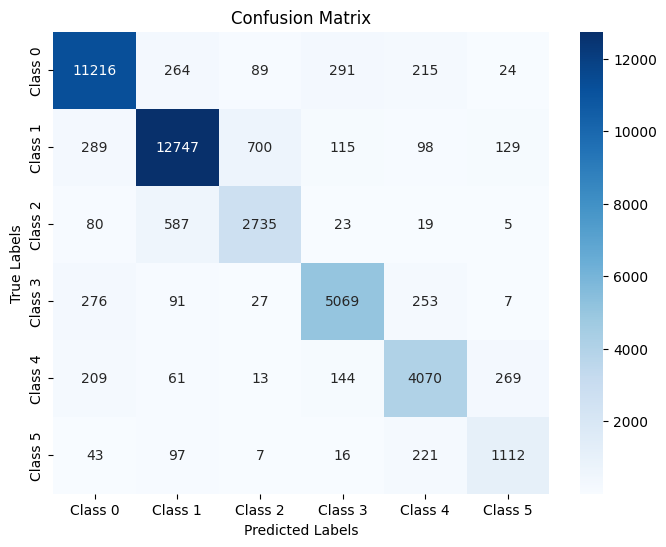


Model saved as 'tfidf_bigru_model_9.h5'



In [ ]:
tfidf_bigru_model_9, tfidf_bigru_metrics_9, tfidf_bigru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bigru"
)

tfidf_bigru_model_9.save('tfidf_bigru_model_9.h5')
print("\nModel saved as 'tfidf_bigru_model_9.h5'\n")

## LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step - accuracy: 0.8284 - loss: 0.5072 - val_accuracy: 0.8814 - val_loss: 0.3303
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - accuracy: 0.8801 - loss: 0.3470 - val_accuracy: 0.8825 - val_loss: 0.3443
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 183s 4ms/step - accuracy: 0.8845 - loss: 0.3274 - val_accuracy: 0.8852 - val_loss: 0.3731
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - accuracy: 0.8868 - loss: 0.3143 - val_accuracy: 0.8807 - val_loss: 0.4294
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - accuracy: 0.8890 - loss: 0.3010 - val_accuracy: 0.8839 - val_loss: 0.4704
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step - accuracy: 0.8897 - loss: 0.2961 - val_accuracy: 0.8818 - val_loss: 0.5778
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



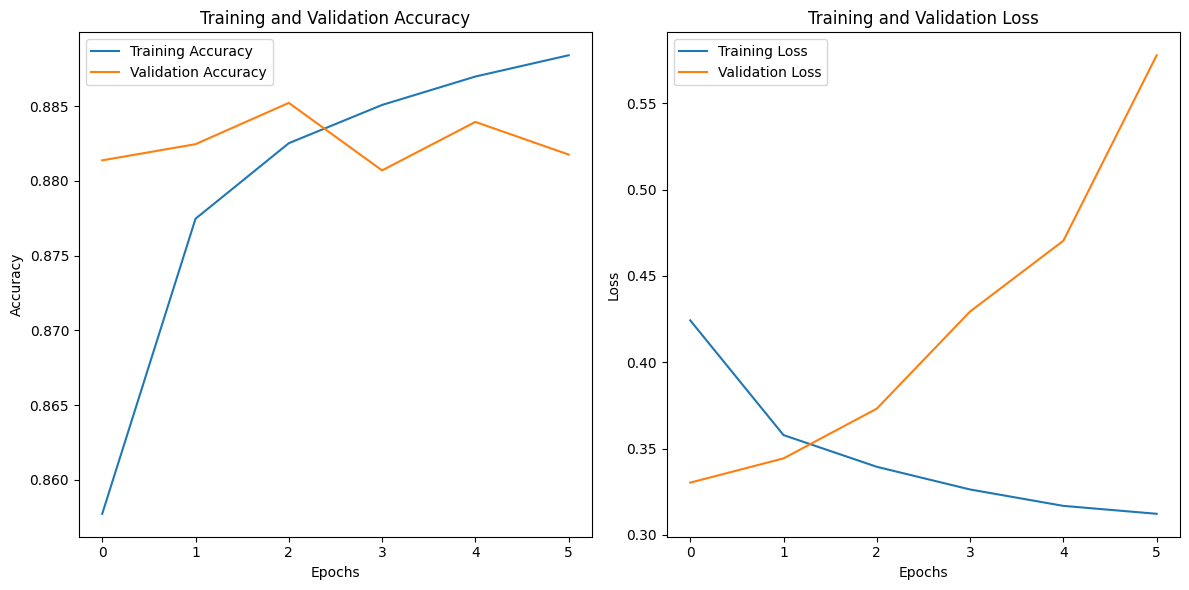

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     12099
           1       0.87      0.94      0.91     14078
           2       0.88      0.63      0.73      3449
           3       0.92      0.84      0.88      5723
           4       0.84      0.86      0.85      4766
           5       0.73      0.82      0.78      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.84      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.31226083636283875
Val Loss: 0.5777705311775208
Test Loss: 0.3236268162727356
AUC: 0.9866323322970292
Accuracy: 0.8820263743400574
Precision: 0.8834503577113988
Recall: 0.8820263872533705
F1-Score: 0.880163124375275

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


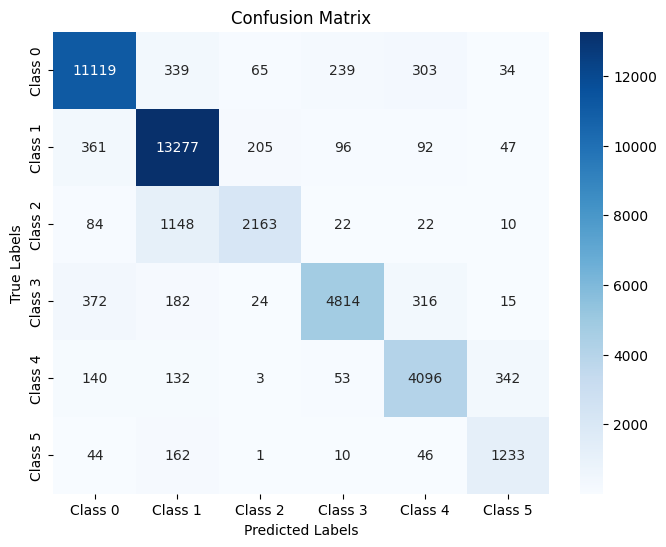


Model saved as 'tfidf_lstm_model_1.h5'



In [ ]:
tfidf_lstm_model_1, tfidf_lstm_metrics_1, tfidf_lstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_1.save('tfidf_lstm_model_1.h5')
print("\nModel saved as 'tfidf_lstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step - accuracy: 0.8311 - loss: 0.4451 - val_accuracy: 0.8909 - val_loss: 0.2418
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - accuracy: 0.8942 - loss: 0.2369 - val_accuracy: 0.8919 - val_loss: 0.2360
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - accuracy: 0.9007 - loss: 0.2159 - val_accuracy: 0.8914 - val_loss: 0.2365
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.9056 - loss: 0.2006 - val_accuracy: 0.8919 - val_loss: 0.2467
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 159s 4ms/step - accuracy: 0.9089 - loss: 0.1892 - val_accuracy: 0.8901 - val_loss: 0.2609
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.9126 - loss: 0.1783 - val_accuracy: 0.8908 - val_loss: 0.2712
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.9174 - loss: 0.1668 - val_accuracy: 0.8869 - val_loss: 0.2946
Epoch 7: early stopping
Restoring model weights from th

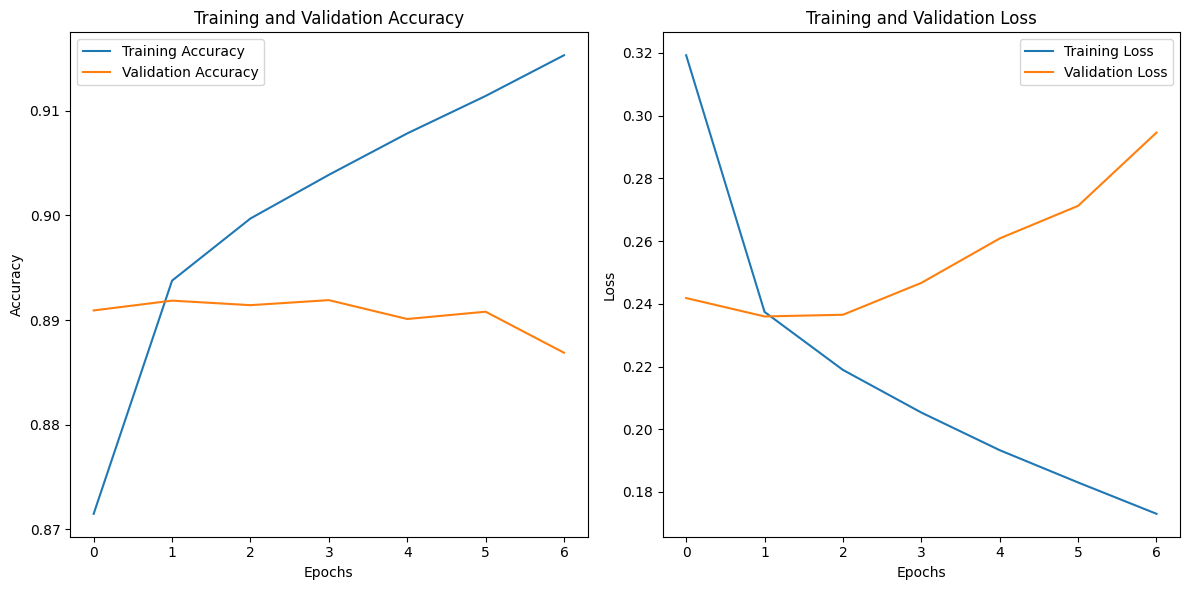

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     12099
           1       0.90      0.93      0.92     14078
           2       0.89      0.66      0.76      3449
           3       0.87      0.91      0.89      5723
           4       0.87      0.82      0.85      4766
           5       0.72      0.81      0.76      1496

    accuracy                           0.89     41611
   macro avg       0.86      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.17303131520748138
Val Loss: 0.2946039140224457
Test Loss: 0.23835815489292145
AUC: 0.9922042915343304
Accuracy: 0.8912307024002075
Precision: 0.8916616728968663
Recall: 0.8912306841940832
F1-Score: 0.8897342585461455

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


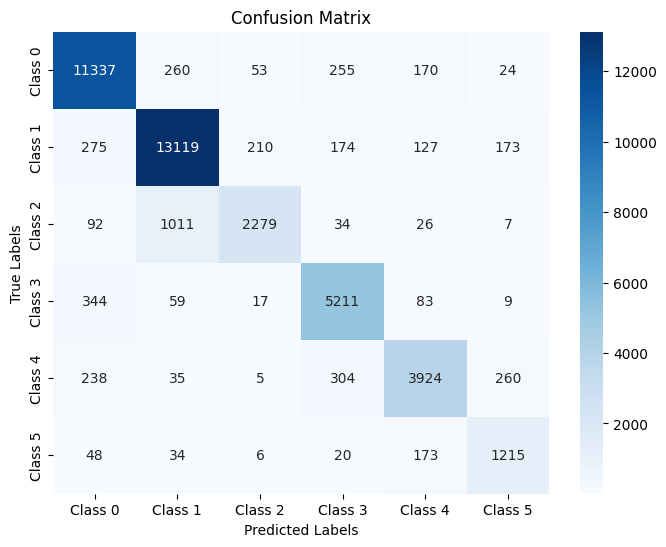


Model saved as 'tfidf_lstm_model_2.h5'



In [ ]:
tfidf_lstm_model_2, tfidf_lstm_metrics_2, tfidf_lstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_2.save('tfidf_lstm_model_2.h5')
print("\nModel saved as 'tfidf_lstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 164s 4ms/step - accuracy: 0.6893 - loss: 0.8529 - val_accuracy: 0.8894 - val_loss: 0.2676
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.8952 - loss: 0.2667 - val_accuracy: 0.8898 - val_loss: 0.2419
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.8991 - loss: 0.2336 - val_accuracy: 0.8908 - val_loss: 0.2335
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.9009 - loss: 0.2204 - val_accuracy: 0.8885 - val_loss: 0.2312
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.9012 - loss: 0.2137 - val_accuracy: 0.8910 - val_loss: 0.2290
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.9049 - loss: 0.2074 - val_accuracy: 0.8920 - val_loss: 0.2301
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.9047 - loss: 0.2044 - val_accuracy: 0.8893 - val_loss: 0.2302
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/s

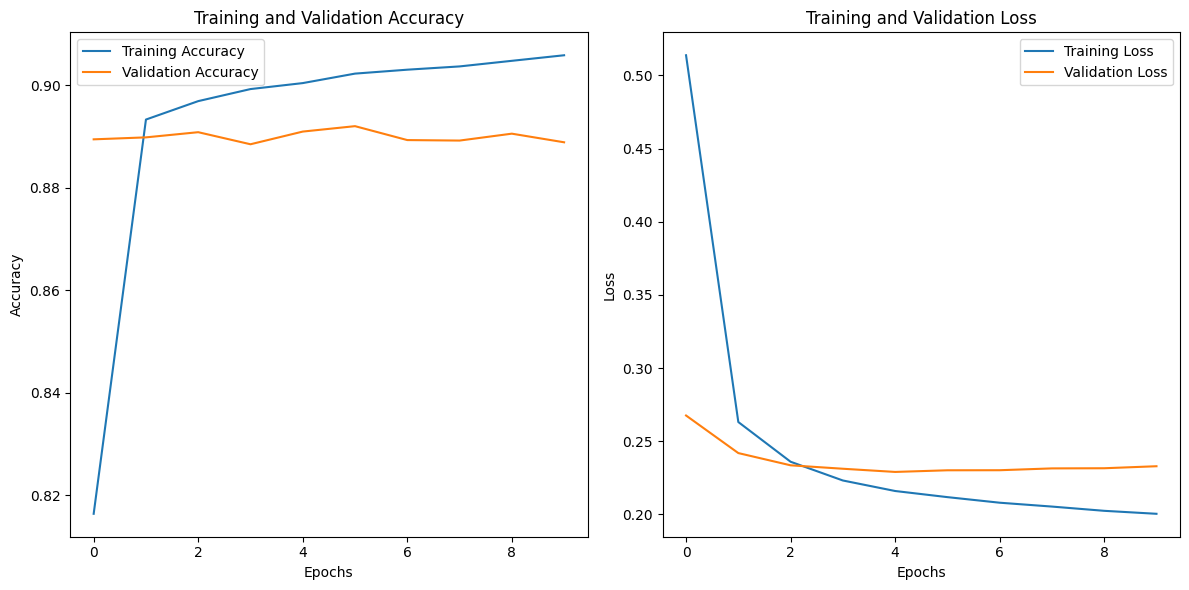

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.92      0.91      0.91     14078
           2       0.80      0.75      0.77      3449
           3       0.87      0.92      0.89      5723
           4       0.86      0.82      0.84      4766
           5       0.71      0.76      0.73      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.200400248169899
Val Loss: 0.23291203379631042
Test Loss: 0.2311471402645111
AUC: 0.9923726916700778
Accuracy: 0.8891639113426208
Precision: 0.8890130037839474
Recall: 0.8891639230011296
F1-Score: 0.888862456739424

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


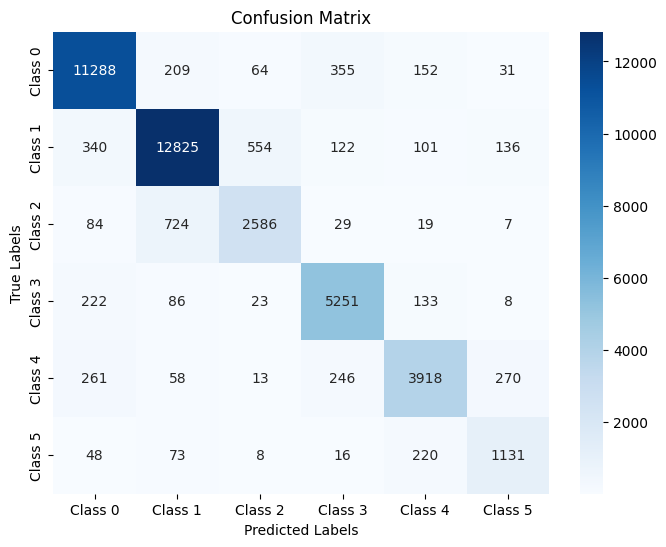


Model saved as 'tfidf_lstm_model_3.h5'



In [ ]:
tfidf_lstm_model_3, tfidf_lstm_metrics_3, tfidf_lstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_3.save('tfidf_lstm_model_3.h5')
print("\nModel saved as 'tfidf_lstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - accuracy: 0.8337 - loss: 0.4702 - val_accuracy: 0.8821 - val_loss: 0.2941
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.8856 - loss: 0.3002 - val_accuracy: 0.8838 - val_loss: 0.3090
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.8940 - loss: 0.2730 - val_accuracy: 0.8837 - val_loss: 0.3678
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9000 - loss: 0.2518 - val_accuracy: 0.8782 - val_loss: 0.4043
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9030 - loss: 0.2391 - val_accuracy: 0.8807 - val_loss: 0.4438
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.9065 - loss: 0.2289 - val_accuracy: 0.8822 - val_loss: 0.5434
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



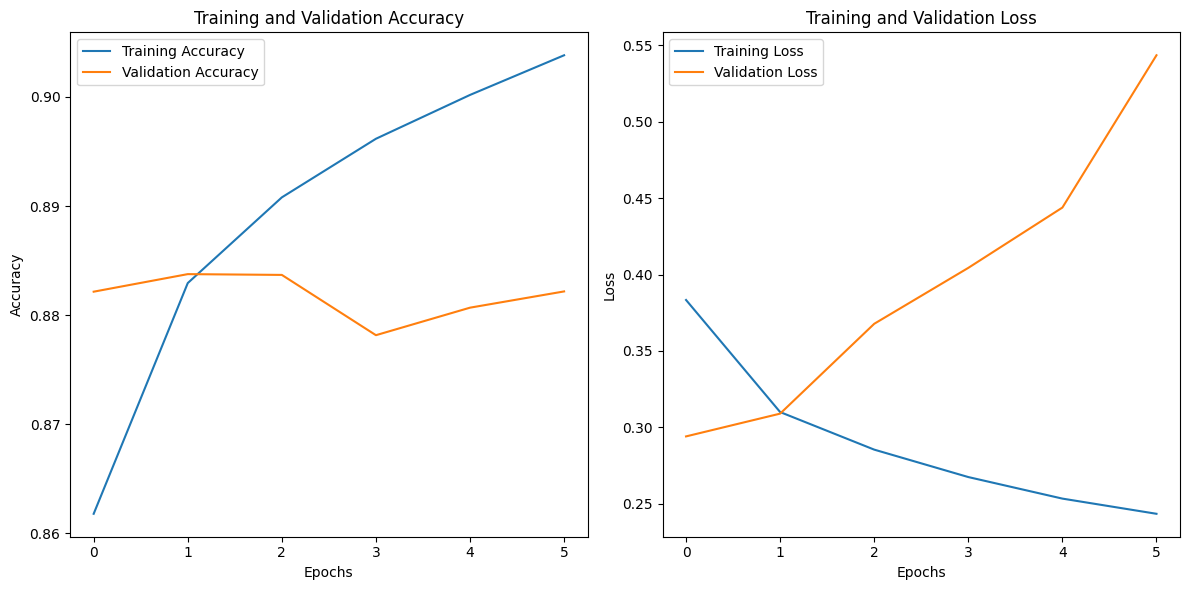

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     12099
           1       0.88      0.94      0.91     14078
           2       0.93      0.59      0.72      3449
           3       0.91      0.85      0.88      5723
           4       0.83      0.86      0.84      4766
           5       0.73      0.80      0.76      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.83      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.24352896213531494
Val Loss: 0.5433604717254639
Test Loss: 0.2904716730117798
AUC: 0.9886743582094072
Accuracy: 0.8808248043060303
Precision: 0.8832646553164076
Recall: 0.8808247819086299
F1-Score: 0.8782070606139138

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


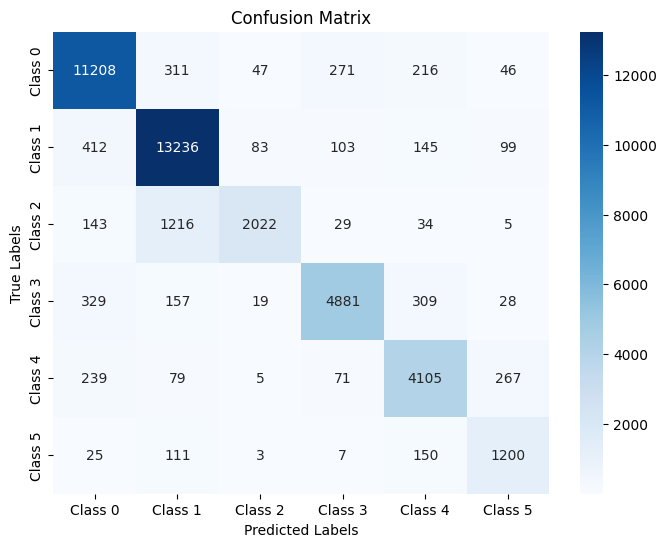


Model saved as 'tfidf_lstm_model_4.h5'



In [ ]:
tfidf_lstm_model_4, tfidf_lstm_metrics_4, tfidf_lstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_4.save('tfidf_lstm_model_4.h5')
print("\nModel saved as 'tfidf_lstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.8210 - loss: 0.4750 - val_accuracy: 0.8909 - val_loss: 0.2421
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.8956 - loss: 0.2331 - val_accuracy: 0.8904 - val_loss: 0.2332
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9007 - loss: 0.2113 - val_accuracy: 0.8939 - val_loss: 0.2358
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9052 - loss: 0.1968 - val_accuracy: 0.8905 - val_loss: 0.2404
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9093 - loss: 0.1825 - val_accuracy: 0.8900 - val_loss: 0.2494
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9132 - loss: 0.1714 - val_accuracy: 0.8889 - val_loss: 0.2616
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9177 - loss: 0.1597 - val_accuracy: 0.8872 - val_loss: 0.2782
Epoch 7: early stopping
Restoring model weights from the end o

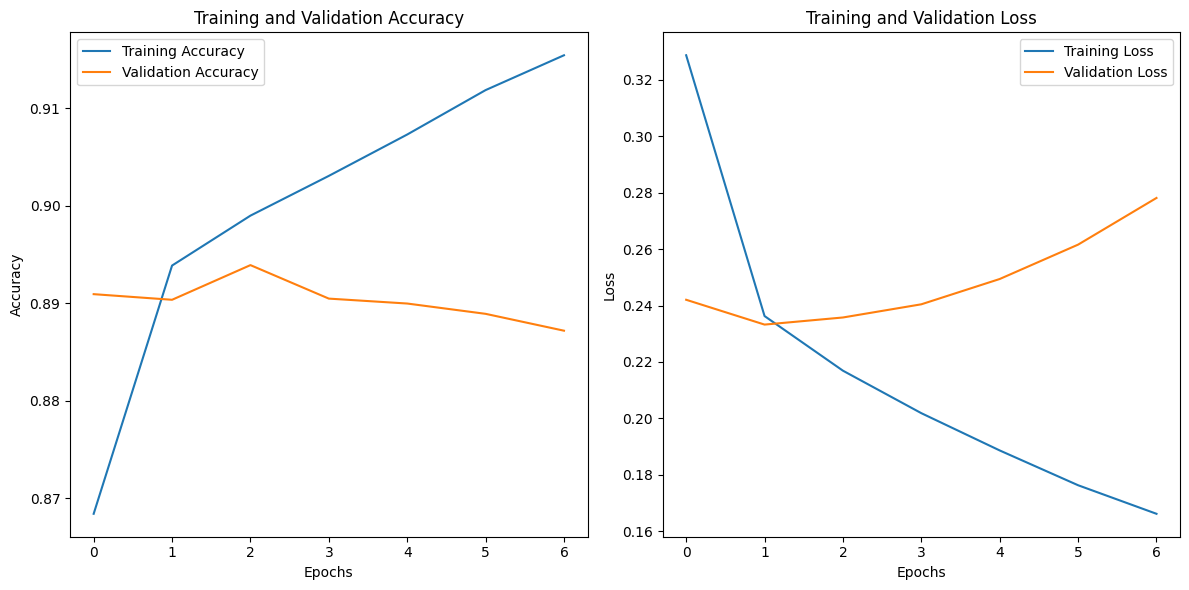

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.93      0.90      0.91     14078
           2       0.77      0.82      0.79      3449
           3       0.92      0.86      0.89      5723
           4       0.79      0.93      0.86      4766
           5       0.79      0.66      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.1661427617073059
Val Loss: 0.27816420793533325
Test Loss: 0.23366986215114594
AUC: 0.9924182451087299
Accuracy: 0.8905337452888489
Precision: 0.8932441704662105
Recall: 0.8905337530941337
F1-Score: 0.8907674894288181

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


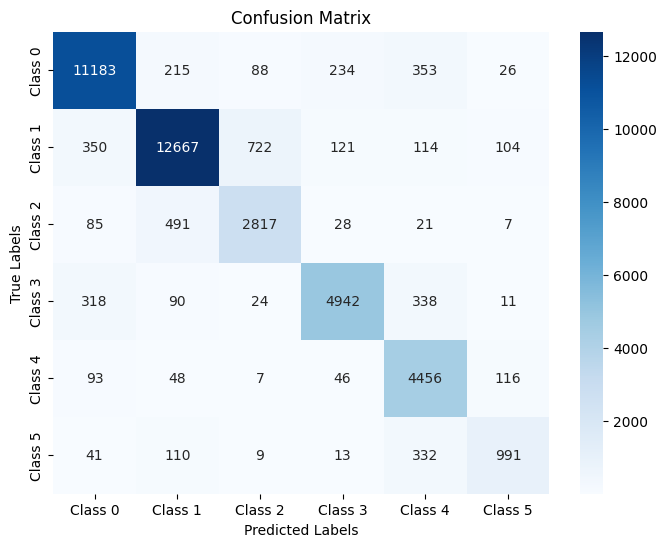


Model saved as 'tfidf_lstm_model_5.h5'



In [ ]:
tfidf_lstm_model_5, tfidf_lstm_metrics_5, tfidf_lstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_5.save('tfidf_lstm_model_5.h5')
print("\nModel saved as 'tfidf_lstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.6533 - loss: 0.9490 - val_accuracy: 0.8833 - val_loss: 0.2987
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.8897 - loss: 0.2984 - val_accuracy: 0.8878 - val_loss: 0.2638
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.8973 - loss: 0.2585 - val_accuracy: 0.8882 - val_loss: 0.2452
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9002 - loss: 0.2342 - val_accuracy: 0.8900 - val_loss: 0.2359
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9027 - loss: 0.2189 - val_accuracy: 0.8888 - val_loss: 0.2333
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9020 - loss: 0.2120 - val_accuracy: 0.8892 - val_loss: 0.2322
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9038 - loss: 0.2053 - val_accuracy: 0.8890 - val_loss: 0.2323
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - ac

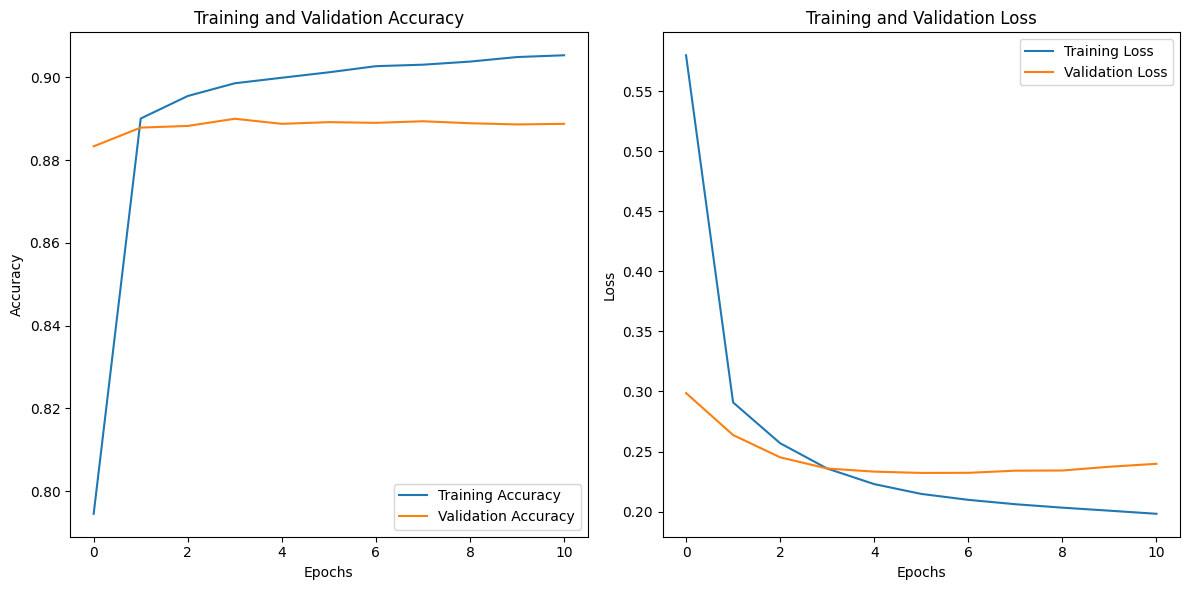

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.92      0.91      0.91     14078
           2       0.77      0.79      0.78      3449
           3       0.89      0.89      0.89      5723
           4       0.85      0.84      0.84      4766
           5       0.73      0.71      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19822381436824799
Val Loss: 0.23982523381710052
Test Loss: 0.2354736179113388
AUC: 0.9921931207288096
Accuracy: 0.8883468508720398
Precision: 0.8883245763546304
Recall: 0.8883468313667059
F1-Score: 0.8882948572206328

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


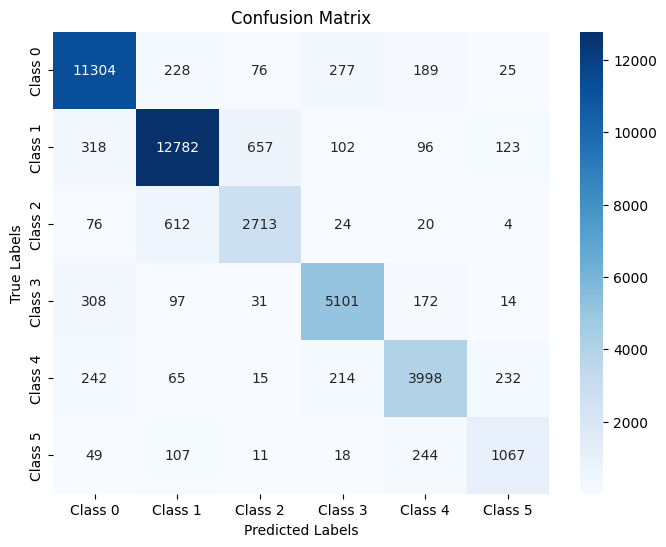


Model saved as 'tfidf_lstm_model_6.h5'



In [ ]:
tfidf_lstm_model_6, tfidf_lstm_metrics_6, tfidf_lstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_6.save('tfidf_lstm_model_6.h5')
print("\nModel saved as 'tfidf_lstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.8331 - loss: 0.4541 - val_accuracy: 0.8833 - val_loss: 0.2836
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8908 - loss: 0.2674 - val_accuracy: 0.8823 - val_loss: 0.2860
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9024 - loss: 0.2273 - val_accuracy: 0.8838 - val_loss: 0.3299
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9118 - loss: 0.1992 - val_accuracy: 0.8819 - val_loss: 0.3884
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9169 - loss: 0.1811 - val_accuracy: 0.8789 - val_loss: 0.4891
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9214 - loss: 0.1720 - val_accuracy: 0.8757 - val_loss: 0.5026
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



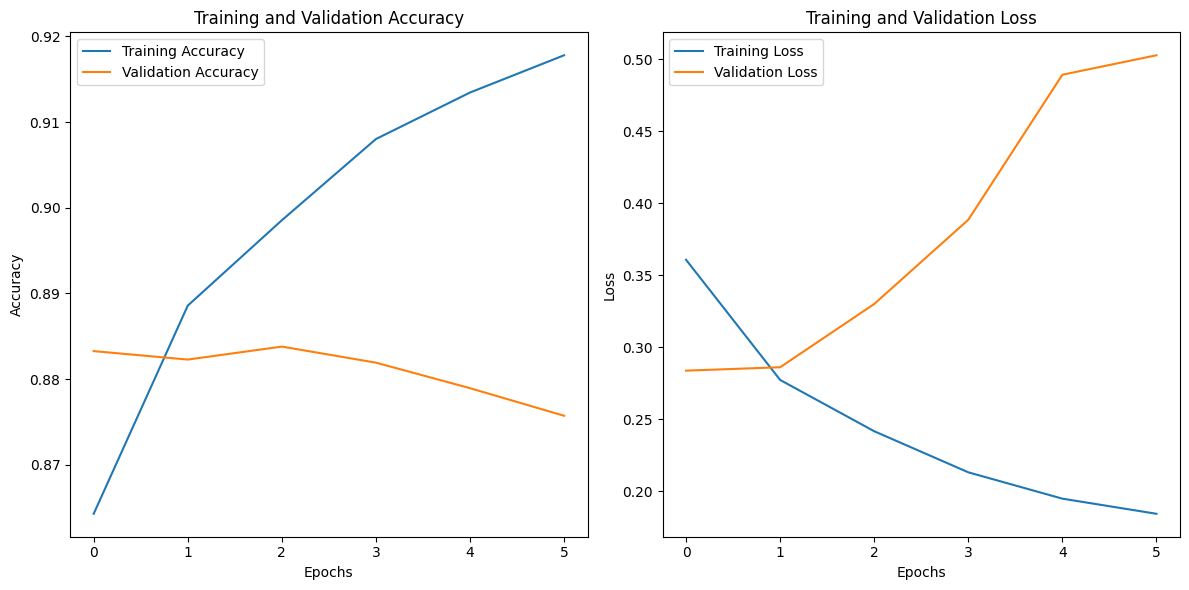

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     12099
           1       0.87      0.95      0.91     14078
           2       0.88      0.63      0.73      3449
           3       0.87      0.90      0.88      5723
           4       0.87      0.82      0.85      4766
           5       0.71      0.88      0.78      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.84      0.84     41611
weighted avg       0.89      0.88      0.88     41611


Metrics:

Train Loss: 0.18421867489814758
Val Loss: 0.5026209950447083
Test Loss: 0.28310731053352356
AUC: 0.9893833283516709
Accuracy: 0.8826512098312378
Precision: 0.8853240153693668
Recall: 0.8826512220326356
F1-Score: 0.8810818738019999

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


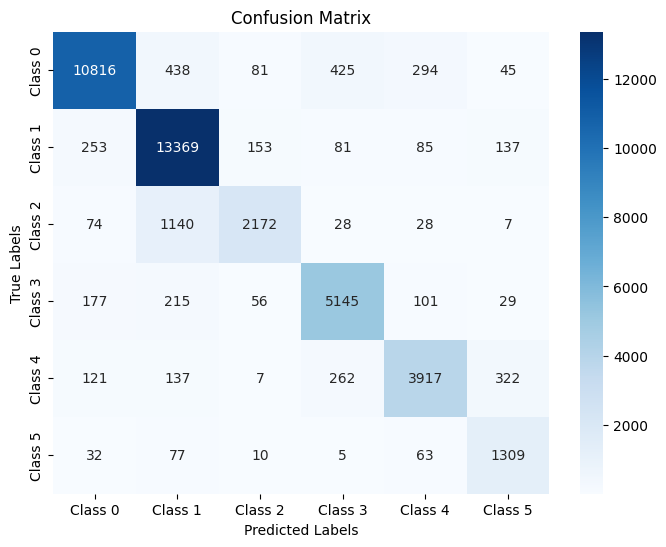


Model saved as 'tfidf_lstm_model_7.h5'



In [ ]:
tfidf_lstm_model_7, tfidf_lstm_metrics_7, tfidf_lstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_7.save('tfidf_lstm_model_7.h5')
print("\nModel saved as 'tfidf_lstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.8112 - loss: 0.5050 - val_accuracy: 0.8876 - val_loss: 0.2452
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8957 - loss: 0.2320 - val_accuracy: 0.8884 - val_loss: 0.2382
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8997 - loss: 0.2135 - val_accuracy: 0.8906 - val_loss: 0.2366
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9045 - loss: 0.1963 - val_accuracy: 0.8910 - val_loss: 0.2407
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9085 - loss: 0.1832 - val_accuracy: 0.8874 - val_loss: 0.2469
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9137 - loss: 0.1718 - val_accuracy: 0.8885 - val_loss: 0.2605
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9166 - loss: 0.1607 - val_accuracy: 0.8851 - val_loss: 0.2754
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - ac

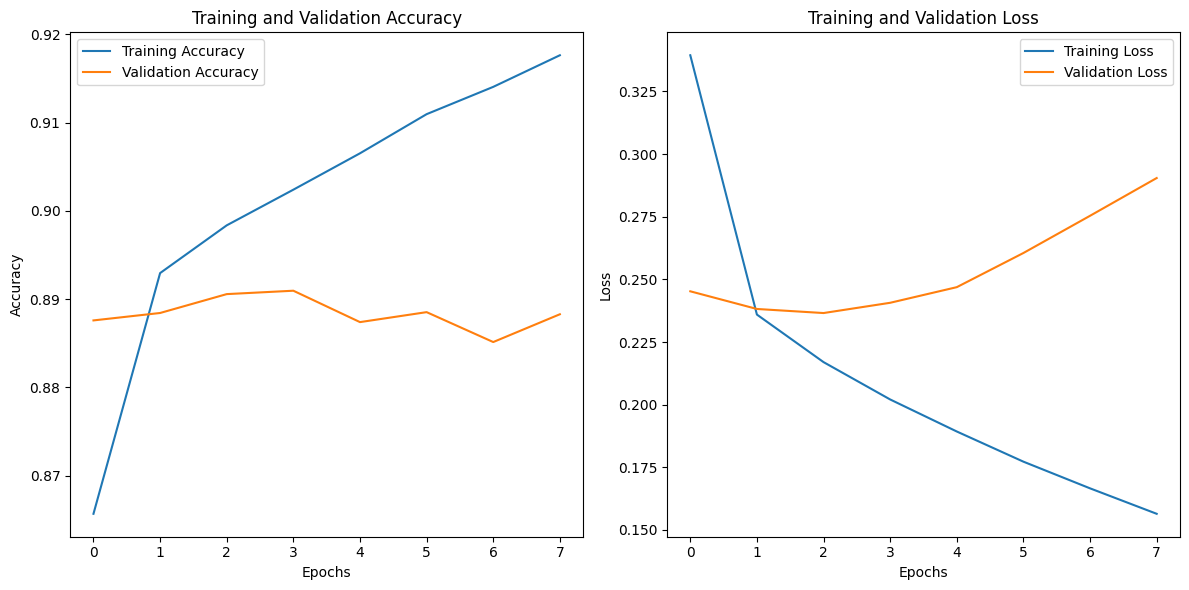

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.93      0.89      0.91     14078
           2       0.75      0.85      0.79      3449
           3       0.87      0.91      0.89      5723
           4       0.86      0.83      0.85      4766
           5       0.79      0.64      0.71      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.84      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.15645509958267212
Val Loss: 0.2904297113418579
Test Loss: 0.2387217879295349
AUC: 0.9921877543485055
Accuracy: 0.8885390758514404
Precision: 0.889900347788008
Recall: 0.8885390882218644
F1-Score: 0.8884262349888329

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


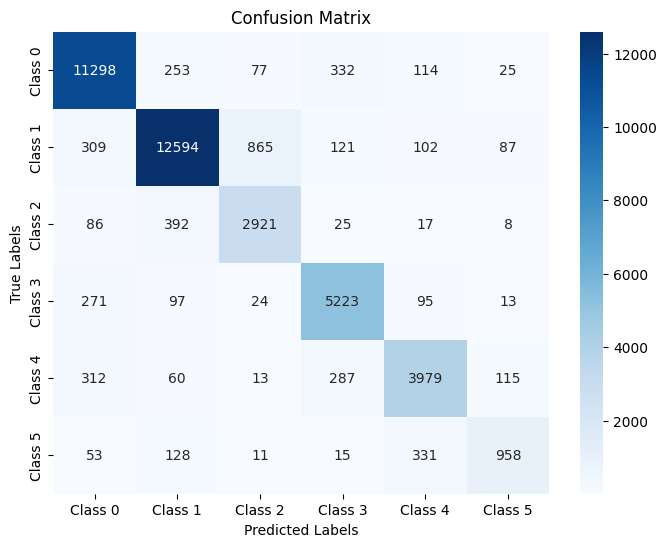


Model saved as 'tfidf_lstm_model_8.h5'



In [ ]:
tfidf_lstm_model_8, tfidf_lstm_metrics_8, tfidf_lstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_8.save('tfidf_lstm_model_8.h5')
print("\nModel saved as 'tfidf_lstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.5909 - loss: 1.1039 - val_accuracy: 0.8832 - val_loss: 0.3035
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8890 - loss: 0.3014 - val_accuracy: 0.8868 - val_loss: 0.2698
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8969 - loss: 0.2657 - val_accuracy: 0.8875 - val_loss: 0.2570
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8993 - loss: 0.2490 - val_accuracy: 0.8871 - val_loss: 0.2480
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9022 - loss: 0.2318 - val_accuracy: 0.8880 - val_loss: 0.2416
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9037 - loss: 0.2199 - val_accuracy: 0.8882 - val_loss: 0.2368
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9039 - loss: 0.2129 - val_accuracy: 0.8876 - val_loss: 0.2350
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - ac

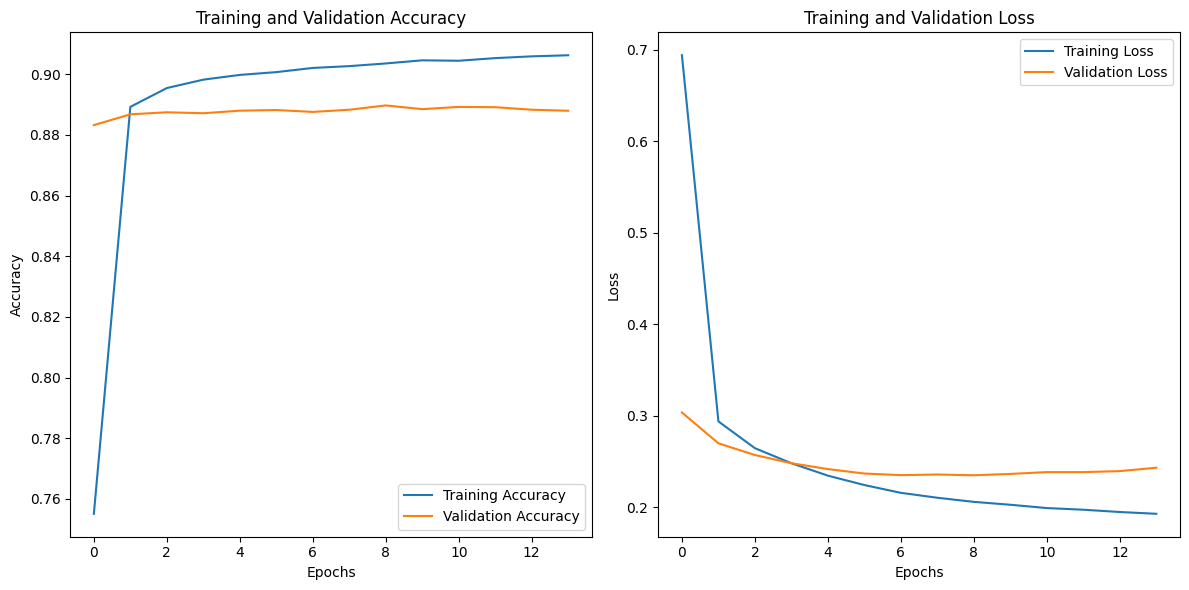

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.91      0.92      0.92     14078
           2       0.81      0.73      0.77      3449
           3       0.89      0.89      0.89      5723
           4       0.84      0.85      0.84      4766
           5       0.69      0.80      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19275735318660736
Val Loss: 0.2431088387966156
Test Loss: 0.23572108149528503
AUC: 0.9921533368804091
Accuracy: 0.8883468508720398
Precision: 0.8887413376967839
Recall: 0.8883468313667059
F1-Score: 0.8882231168179384

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


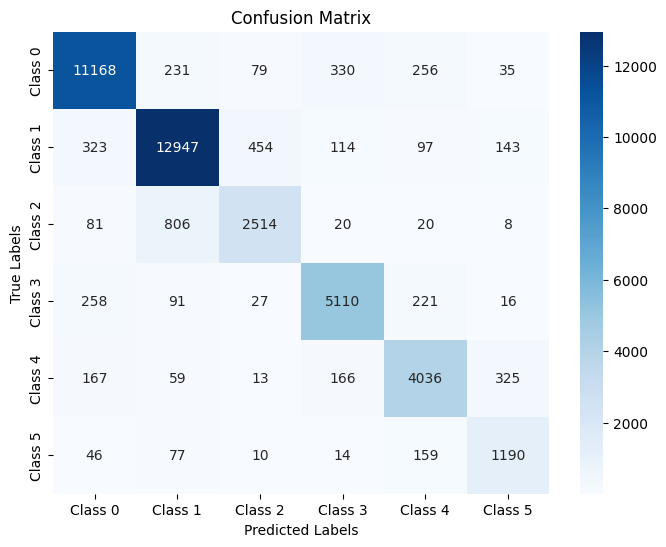


Model saved as 'tfidf_lstm_model_9.h5'



In [ ]:
tfidf_lstm_model_9, tfidf_lstm_metrics_9, tfidf_lstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="lstm"
)

tfidf_lstm_model_9.save('tfidf_lstm_model_9.h5')
print("\nModel saved as 'tfidf_lstm_model_9.h5'\n")

## Bi-LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 236s 6ms/step - accuracy: 0.8275 - loss: 0.5136 - val_accuracy: 0.8820 - val_loss: 0.3325
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8823 - loss: 0.3391 - val_accuracy: 0.8820 - val_loss: 0.3352
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8886 - loss: 0.3138 - val_accuracy: 0.8803 - val_loss: 0.4095
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8925 - loss: 0.2984 - val_accuracy: 0.8817 - val_loss: 0.5251
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8944 - loss: 0.2912 - val_accuracy: 0.8800 - val_loss: 0.6691
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8961 - loss: 0.2870 - val_accuracy: 0.8774 - val_loss: 0.8460
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



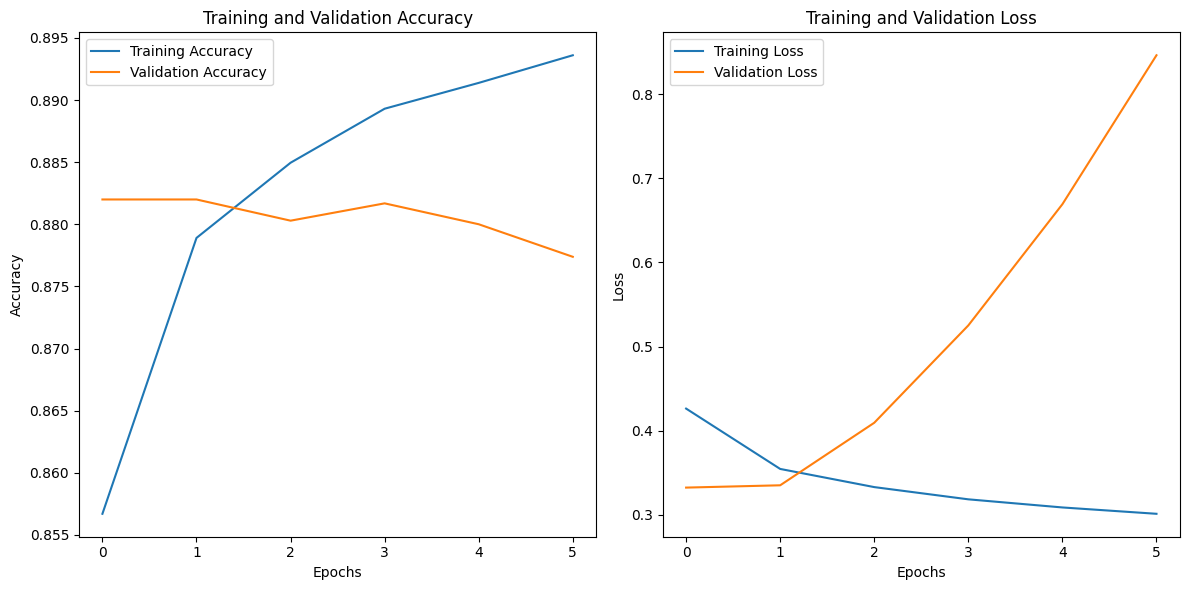

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     12099
           1       0.88      0.94      0.91     14078
           2       0.90      0.60      0.72      3449
           3       0.92      0.84      0.88      5723
           4       0.88      0.80      0.84      4766
           5       0.72      0.81      0.76      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.82      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.30134350061416626
Val Loss: 0.8460431694984436
Test Loss: 0.32698142528533936
AUC: 0.9865583017949136
Accuracy: 0.8797913789749146
Precision: 0.8816408261547717
Recall: 0.879791401312153
F1-Score: 0.8768635228812822

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


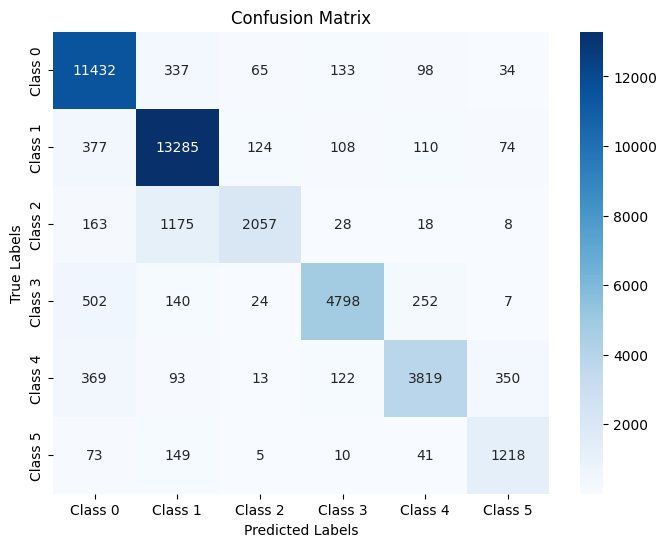


Model saved as 'tfidf_bilstm_model_1.h5'



In [ ]:
tfidf_bilstm_model_1, tfidf_bilstm_metrics_1, tfidf_bilstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_1.save('tfidf_bilstm_model_1.h5')
print("\nModel saved as 'tfidf_bilstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 234s 6ms/step - accuracy: 0.8370 - loss: 0.4291 - val_accuracy: 0.8916 - val_loss: 0.2416
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.8937 - loss: 0.2354 - val_accuracy: 0.8916 - val_loss: 0.2376
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 230s 6ms/step - accuracy: 0.9009 - loss: 0.2148 - val_accuracy: 0.8904 - val_loss: 0.2380
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 229s 5ms/step - accuracy: 0.9075 - loss: 0.1955 - val_accuracy: 0.8928 - val_loss: 0.2433
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 229s 6ms/step - accuracy: 0.9116 - loss: 0.1830 - val_accuracy: 0.8920 - val_loss: 0.2670
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 229s 5ms/step - accuracy: 0.9164 - loss: 0.1687 - val_accuracy: 0.8871 - val_loss: 0.2814
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 229s 6ms/step - accuracy: 0.9205 - loss: 0.1561 - val_accuracy: 0.8854 - val_loss: 0.3192
Epoch 7: early stopping
Restoring model weights from th

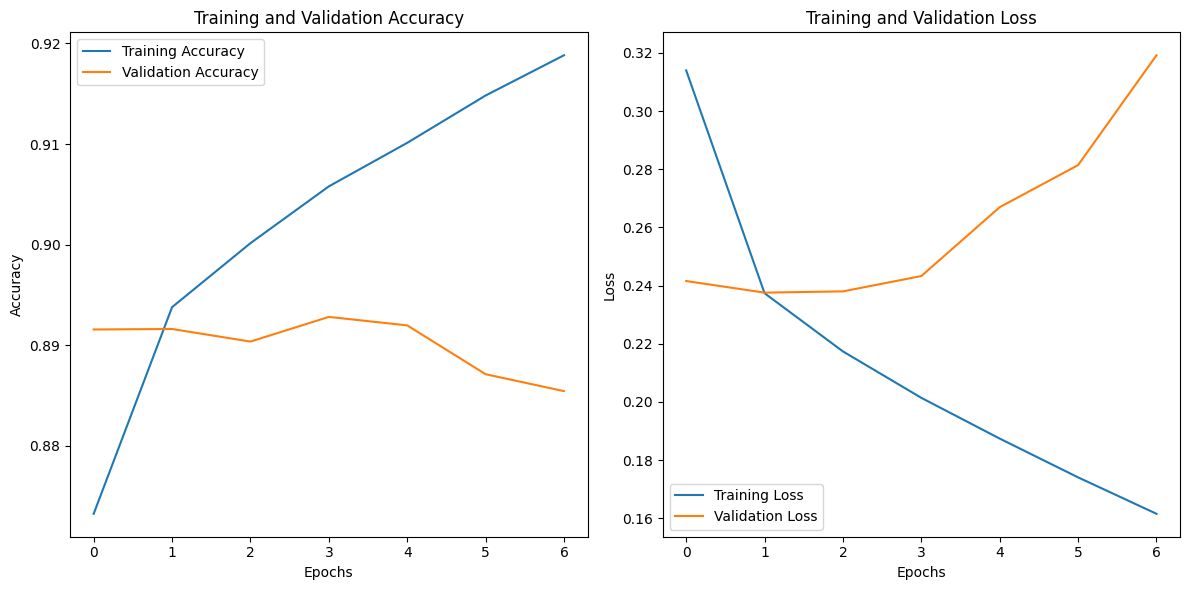

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     12099
           1       0.89      0.96      0.92     14078
           2       0.89      0.65      0.75      3449
           3       0.89      0.89      0.89      5723
           4       0.79      0.95      0.86      4766
           5       0.82      0.64      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.87      0.83      0.84     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.1615462750196457
Val Loss: 0.3192063271999359
Test Loss: 0.2390548288822174
AUC: 0.9922687362555219
Accuracy: 0.8919035792350769
Precision: 0.8949003791349491
Recall: 0.891903583187138
F1-Score: 0.8898684600487012

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


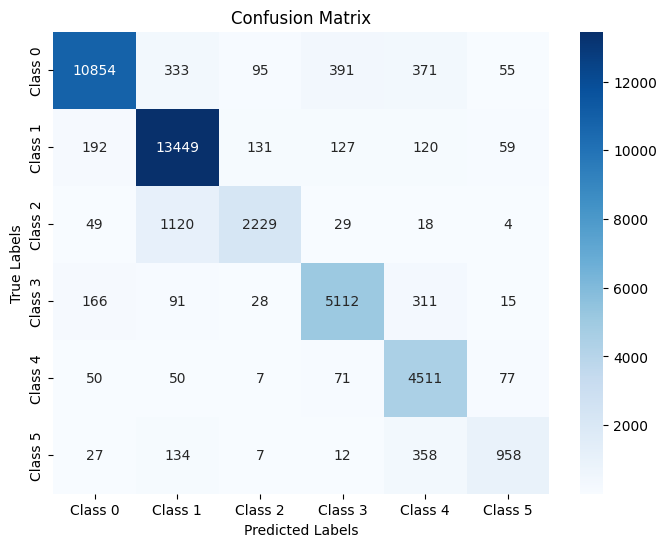


Model saved as 'tfidf_bilstm_model_2.h5'



In [ ]:
tfidf_bilstm_model_2, tfidf_bilstm_metrics_2, tfidf_bilstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_2.save('tfidf_bilstm_model_2.h5')
print("\nModel saved as 'tfidf_bilstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 238s 6ms/step - accuracy: 0.7300 - loss: 0.7572 - val_accuracy: 0.8869 - val_loss: 0.2618
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/step - accuracy: 0.8937 - loss: 0.2611 - val_accuracy: 0.8902 - val_loss: 0.2392
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/step - accuracy: 0.8985 - loss: 0.2306 - val_accuracy: 0.8898 - val_loss: 0.2309
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/step - accuracy: 0.9014 - loss: 0.2161 - val_accuracy: 0.8915 - val_loss: 0.2300
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9024 - loss: 0.2108 - val_accuracy: 0.8922 - val_loss: 0.2302
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 232s 6ms/step - accuracy: 0.9031 - loss: 0.2066 - val_accuracy: 0.8930 - val_loss: 0.2319
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/step - accuracy: 0.9045 - loss: 0.2031 - val_accuracy: 0.8900 - val_loss: 0.2331
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 233s 6ms/s

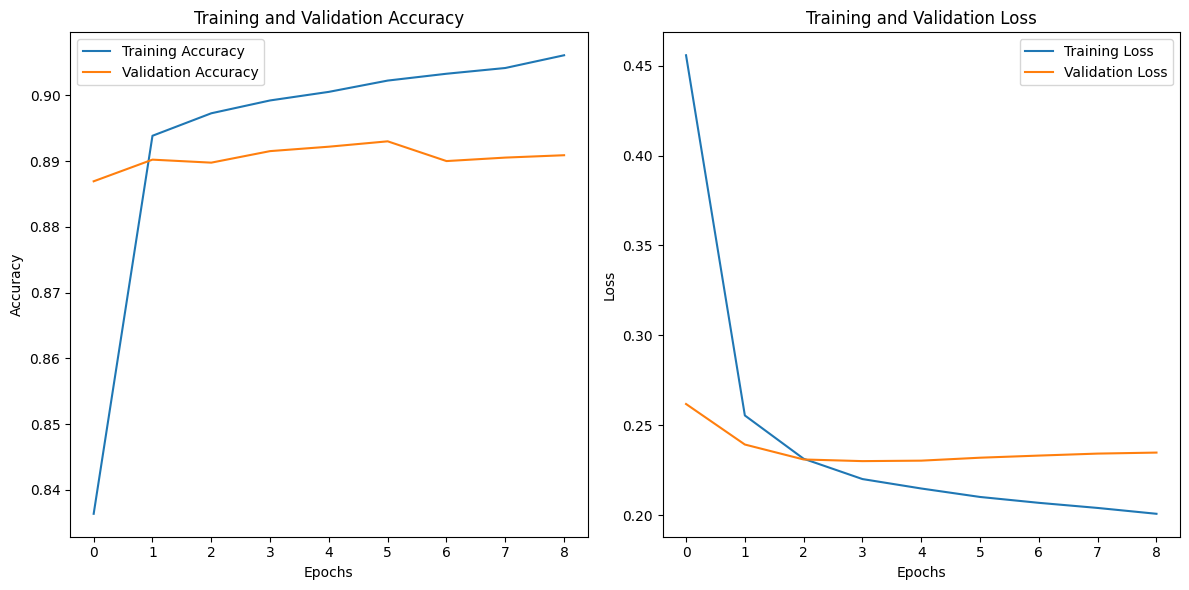

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.91      0.92      0.92     14078
           2       0.80      0.76      0.78      3449
           3       0.88      0.90      0.89      5723
           4       0.85      0.85      0.85      4766
           5       0.73      0.75      0.74      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.20067045092582703
Val Loss: 0.23473380506038666
Test Loss: 0.23229463398456573
AUC: 0.9923556884731037
Accuracy: 0.8900530934333801
Precision: 0.8900432162536157
Recall: 0.8900531109562375
F1-Score: 0.8899395853272187

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


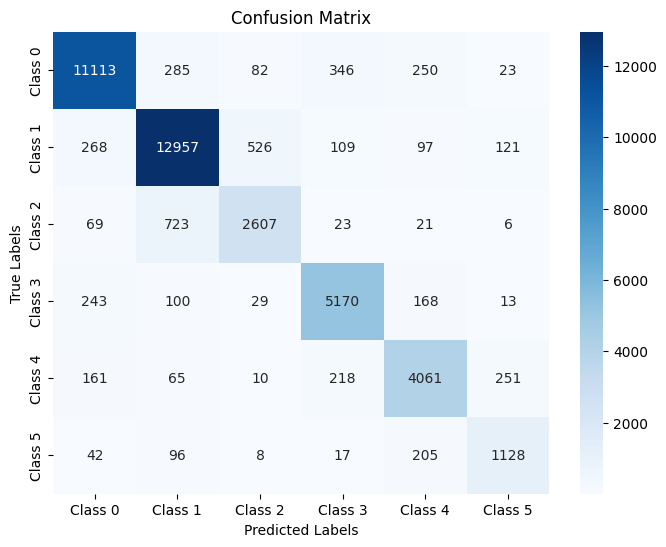


Model saved as 'tfidf_bilstm_model_3.h5'



In [ ]:
tfidf_bilstm_model_3, tfidf_bilstm_metrics_3, tfidf_bilstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_3.save('tfidf_bilstm_model_3.h5')
print("\nModel saved as 'tfidf_bilstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.8316 - loss: 0.4756 - val_accuracy: 0.8816 - val_loss: 0.3012
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.8872 - loss: 0.3025 - val_accuracy: 0.8844 - val_loss: 0.3291
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.8968 - loss: 0.2654 - val_accuracy: 0.8830 - val_loss: 0.3747
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.9056 - loss: 0.2375 - val_accuracy: 0.8774 - val_loss: 0.4790
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.9101 - loss: 0.2238 - val_accuracy: 0.8758 - val_loss: 0.6138
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 117s 6ms/step - accuracy: 0.9137 - loss: 0.2159 - val_accuracy: 0.8782 - val_loss: 0.7268
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



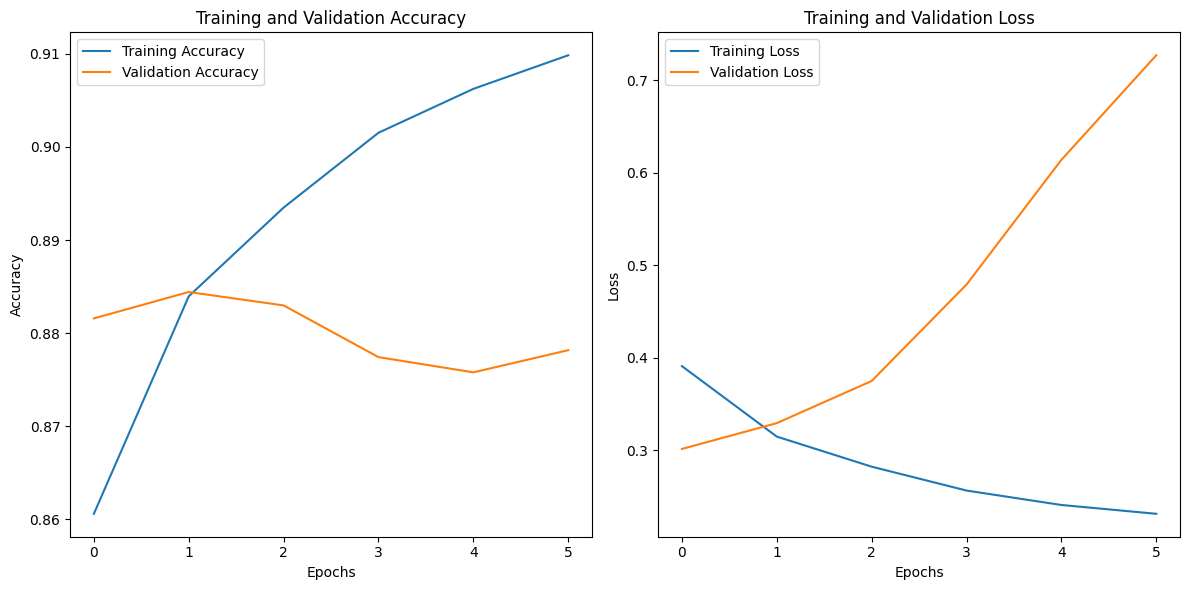

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     12099
           1       0.88      0.94      0.91     14078
           2       0.86      0.63      0.73      3449
           3       0.90      0.86      0.88      5723
           4       0.84      0.85      0.85      4766
           5       0.72      0.85      0.78      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.84      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.23111183941364288
Val Loss: 0.7268328070640564
Test Loss: 0.30150091648101807
AUC: 0.9876655395768846
Accuracy: 0.8830116987228394
Precision: 0.8841315916139548
Recall: 0.8830117036360577
F1-Score: 0.881446878596686

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


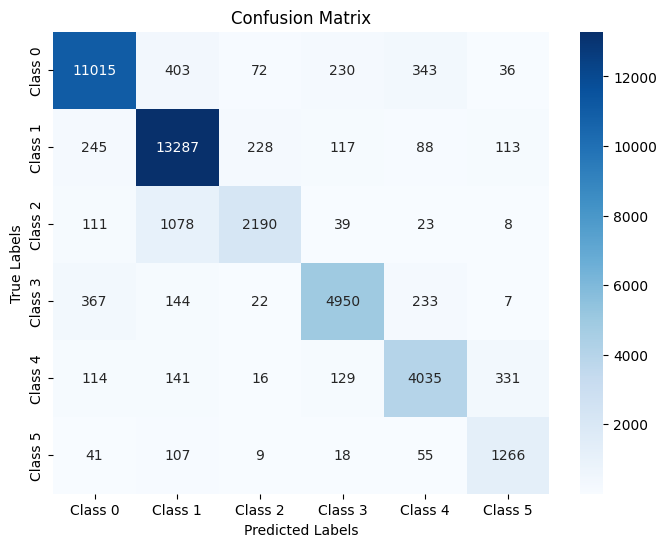


Model saved as 'tfidf_bilstm_model_4.h5'



In [ ]:
tfidf_bilstm_model_4, tfidf_bilstm_metrics_4, tfidf_bilstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_4.save('tfidf_bilstm_model_4.h5')
print("\nModel saved as 'tfidf_bilstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 129s 6ms/step - accuracy: 0.8296 - loss: 0.4515 - val_accuracy: 0.8892 - val_loss: 0.2455
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.8943 - loss: 0.2346 - val_accuracy: 0.8905 - val_loss: 0.2389
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8999 - loss: 0.2130 - val_accuracy: 0.8927 - val_loss: 0.2346
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9056 - loss: 0.1938 - val_accuracy: 0.8897 - val_loss: 0.2490
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9111 - loss: 0.1776 - val_accuracy: 0.8888 - val_loss: 0.2620
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9157 - loss: 0.1650 - val_accuracy: 0.8861 - val_loss: 0.2749
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9204 - loss: 0.1525 - val_accuracy: 0.8852 - val_loss: 0.2953
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/s

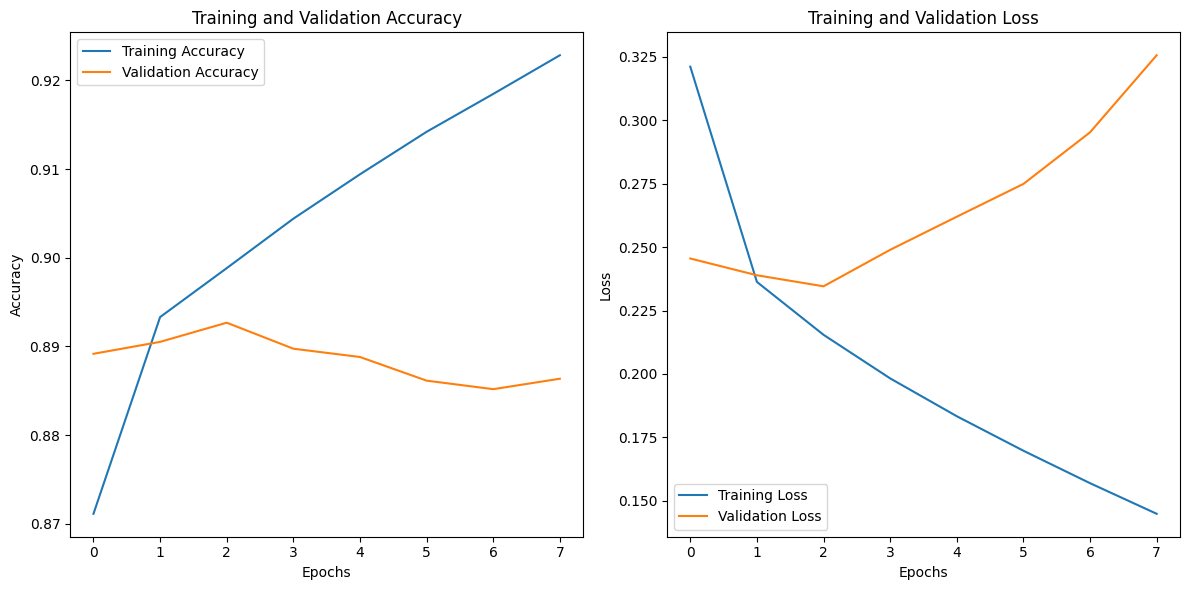

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12099
           1       0.89      0.95      0.92     14078
           2       0.91      0.63      0.75      3449
           3       0.91      0.87      0.89      5723
           4       0.83      0.87      0.85      4766
           5       0.71      0.83      0.76      1496

    accuracy                           0.89     41611
   macro avg       0.86      0.84      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.144853413105011
Val Loss: 0.32568100094795227
Test Loss: 0.23866431415081024
AUC: 0.9922488260529922
Accuracy: 0.890317440032959
Precision: 0.8924527355860402
Recall: 0.8903174641320805
F1-Score: 0.8886989543936684

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


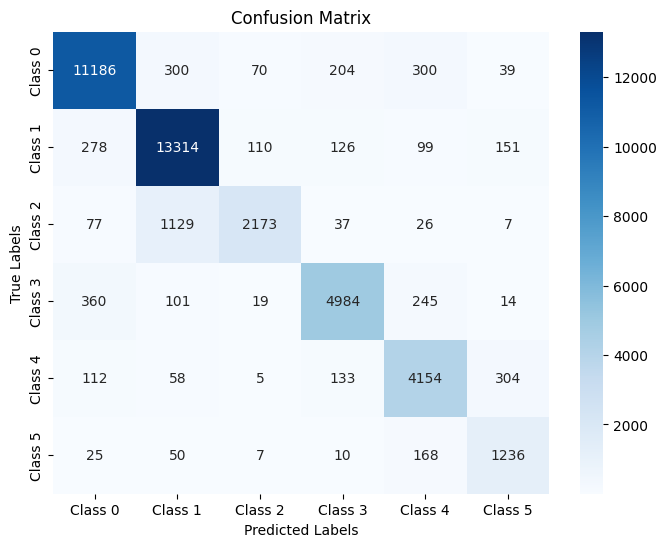


Model saved as 'tfidf_bilstm_model_5.h5'



In [ ]:
tfidf_bilstm_model_5, tfidf_bilstm_metrics_5, tfidf_bilstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_5.save('tfidf_bilstm_model_5.h5')
print("\nModel saved as 'tfidf_bilstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 122s 6ms/step - accuracy: 0.6918 - loss: 0.8599 - val_accuracy: 0.8866 - val_loss: 0.2746
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8939 - loss: 0.2720 - val_accuracy: 0.8888 - val_loss: 0.2484
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 126s 6ms/step - accuracy: 0.8985 - loss: 0.2417 - val_accuracy: 0.8901 - val_loss: 0.2371
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - accuracy: 0.9004 - loss: 0.2228 - val_accuracy: 0.8896 - val_loss: 0.2323
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 133s 6ms/step - accuracy: 0.9022 - loss: 0.2117 - val_accuracy: 0.8895 - val_loss: 0.2312
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - accuracy: 0.9032 - loss: 0.2073 - val_accuracy: 0.8923 - val_loss: 0.2326
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - accuracy: 0.9051 - loss: 0.2017 - val_accuracy: 0.8901 - val_loss: 0.2339
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/s

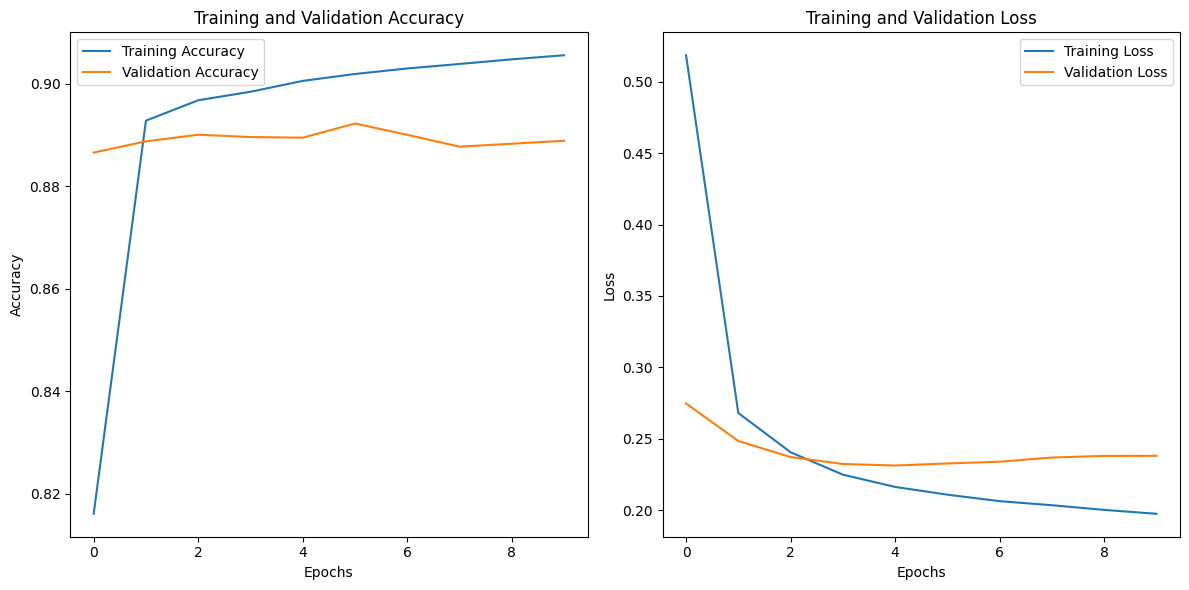

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.92      0.91      0.91     14078
           2       0.79      0.75      0.77      3449
           3       0.89      0.89      0.89      5723
           4       0.83      0.87      0.85      4766
           5       0.72      0.72      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.85      0.85     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.19738081097602844
Val Loss: 0.23797661066055298
Test Loss: 0.23475627601146698
AUC: 0.9921930480620285
Accuracy: 0.8877460360527039
Precision: 0.8877303075901622
Recall: 0.8877460286943356
F1-Score: 0.8876426037215469

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


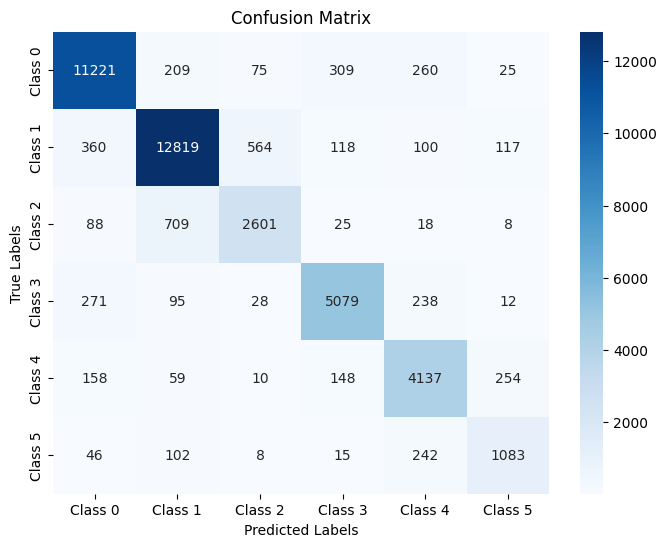


Model saved as 'tfidf_bilstm_model_6.h5'



In [ ]:
tfidf_bilstm_model_6, tfidf_bilstm_metrics_6, tfidf_bilstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_6.save('tfidf_bilstm_model_6.h5')
print("\nModel saved as 'tfidf_bilstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.8333 - loss: 0.4548 - val_accuracy: 0.8824 - val_loss: 0.2817
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.8911 - loss: 0.2633 - val_accuracy: 0.8839 - val_loss: 0.2972
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9039 - loss: 0.2231 - val_accuracy: 0.8804 - val_loss: 0.3637
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9148 - loss: 0.1908 - val_accuracy: 0.8786 - val_loss: 0.4544
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9207 - loss: 0.1719 - val_accuracy: 0.8751 - val_loss: 0.5544
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.9240 - loss: 0.1646 - val_accuracy: 0.8793 - val_loss: 0.6926
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



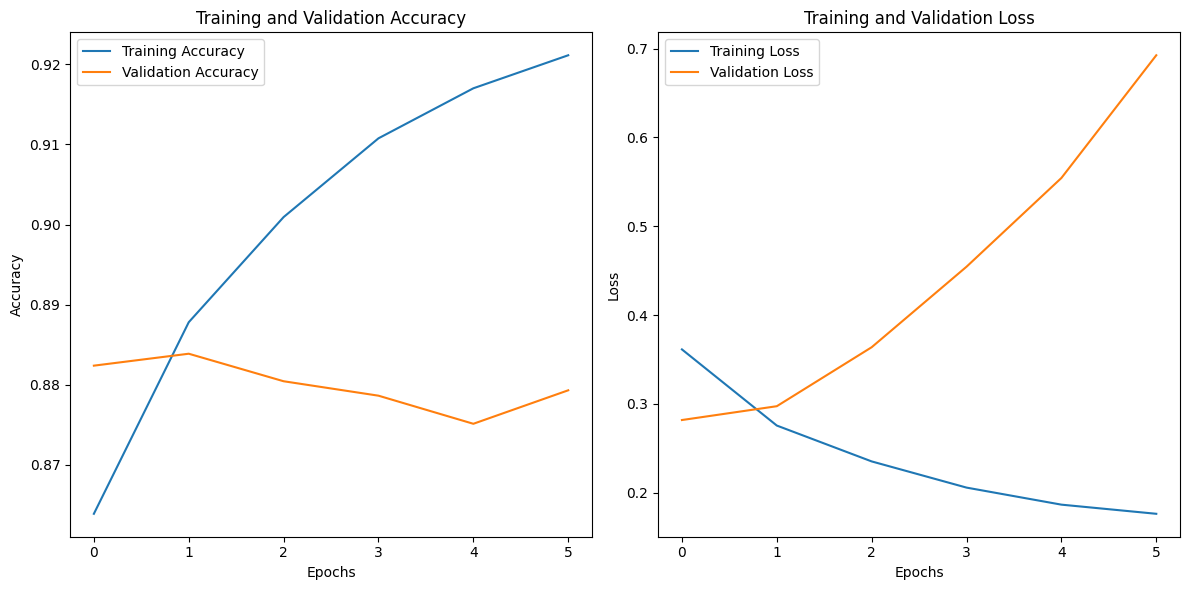

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12099
           1       0.88      0.94      0.91     14078
           2       0.85      0.66      0.74      3449
           3       0.90      0.87      0.89      5723
           4       0.81      0.91      0.85      4766
           5       0.79      0.68      0.73      1496

    accuracy                           0.88     41611
   macro avg       0.86      0.83      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.17603358626365662
Val Loss: 0.6926296353340149
Test Loss: 0.2832094430923462
AUC: 0.9894926329165775
Accuracy: 0.882723331451416
Precision: 0.8837672024901909
Recall: 0.8827233183533201
F1-Score: 0.8812433185313572

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


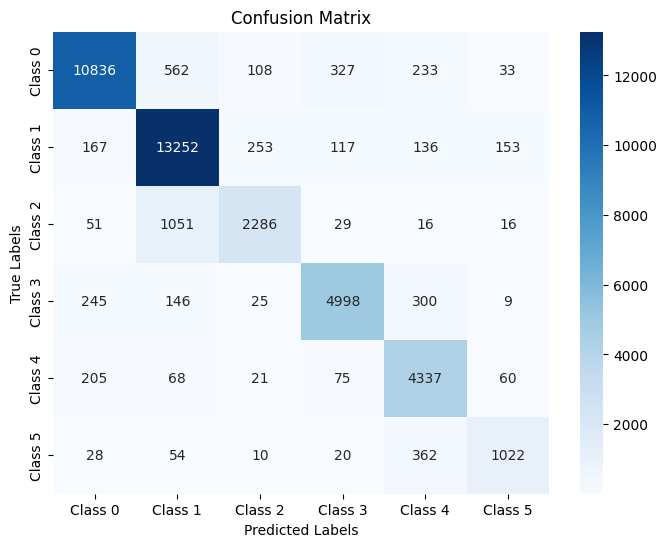


Model saved as 'tfidf_bilstm_model_7.h5'



In [ ]:
tfidf_bilstm_model_7, tfidf_bilstm_metrics_7, tfidf_bilstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_7.save('tfidf_bilstm_model_7.h5')
print("\nModel saved as 'tfidf_bilstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 76s 7ms/step - accuracy: 0.8191 - loss: 0.4818 - val_accuracy: 0.8866 - val_loss: 0.2433
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.8948 - loss: 0.2331 - val_accuracy: 0.8894 - val_loss: 0.2372
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9000 - loss: 0.2107 - val_accuracy: 0.8916 - val_loss: 0.2345
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9052 - loss: 0.1963 - val_accuracy: 0.8880 - val_loss: 0.2468
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9100 - loss: 0.1798 - val_accuracy: 0.8886 - val_loss: 0.2522
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9146 - loss: 0.1683 - val_accuracy: 0.8863 - val_loss: 0.2671
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9185 - loss: 0.1552 - val_accuracy: 0.8860 - val_loss: 0.2917
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - ac

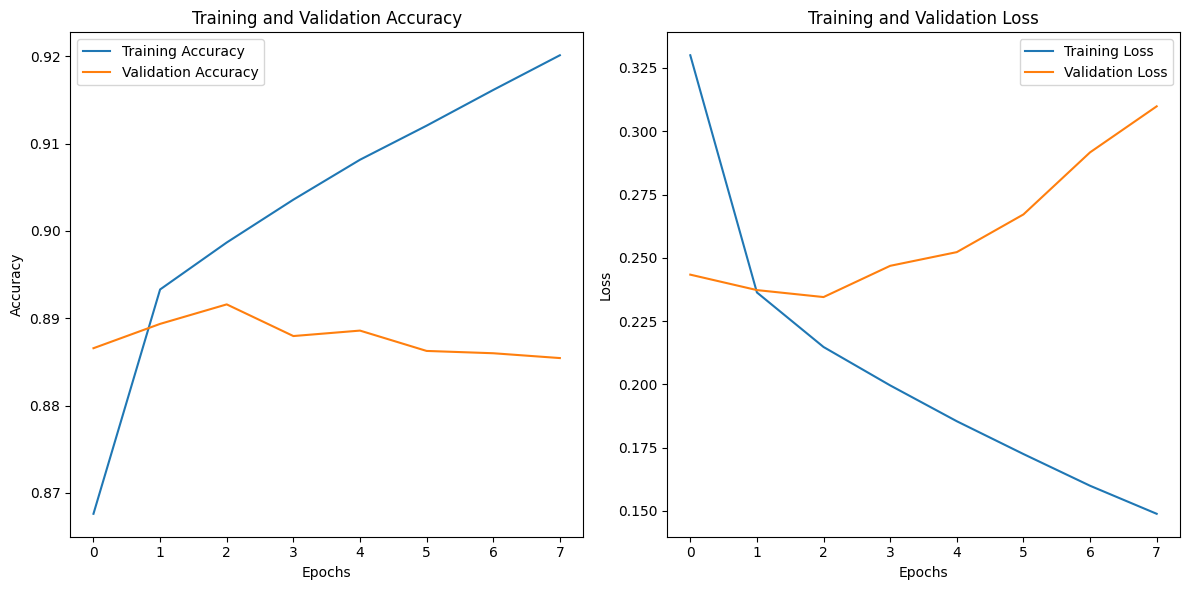

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     12099
           1       0.89      0.95      0.92     14078
           2       0.89      0.65      0.75      3449
           3       0.91      0.87      0.89      5723
           4       0.84      0.87      0.85      4766
           5       0.81      0.65      0.72      1496

    accuracy                           0.89     41611
   macro avg       0.87      0.82      0.84     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.14881357550621033
Val Loss: 0.3098463714122772
Test Loss: 0.23965239524841309
AUC: 0.9921913921805149
Accuracy: 0.8898608684539795
Precision: 0.8895012374562036
Recall: 0.8898608541010791
F1-Score: 0.8873559417470513

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


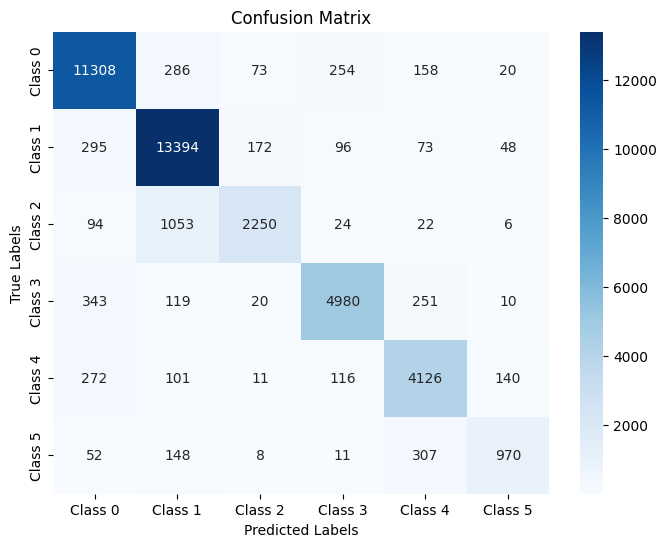


Model saved as 'tfidf_bilstm_model_8.h5'



In [ ]:
tfidf_bilstm_model_8, tfidf_bilstm_metrics_8, tfidf_bilstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_8.save('tfidf_bilstm_model_8.h5')
print("\nModel saved as 'tfidf_bilstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.6329 - loss: 1.0057 - val_accuracy: 0.8875 - val_loss: 0.2883
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.8919 - loss: 0.2881 - val_accuracy: 0.8883 - val_loss: 0.2596
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.8982 - loss: 0.2547 - val_accuracy: 0.8883 - val_loss: 0.2475
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9012 - loss: 0.2347 - val_accuracy: 0.8886 - val_loss: 0.2396
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9023 - loss: 0.2232 - val_accuracy: 0.8886 - val_loss: 0.2348
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9026 - loss: 0.2130 - val_accuracy: 0.8877 - val_loss: 0.2338
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9046 - loss: 0.2055 - val_accuracy: 0.8885 - val_loss: 0.2333
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - ac

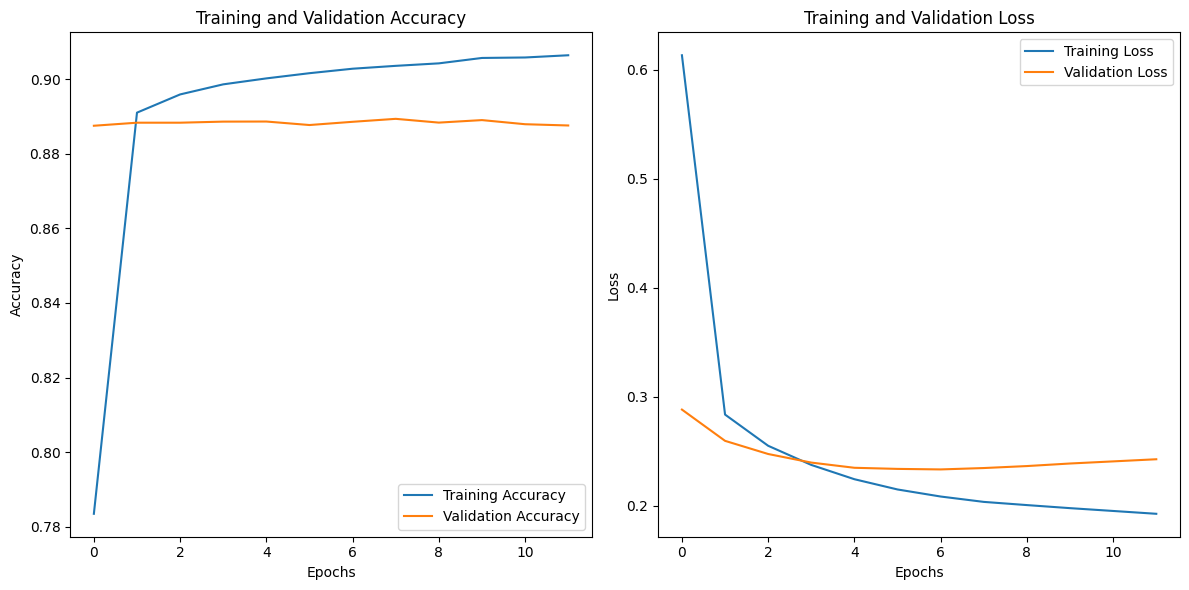

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     12099
           1       0.90      0.93      0.91     14078
           2       0.83      0.70      0.76      3449
           3       0.91      0.87      0.89      5723
           4       0.84      0.84      0.84      4766
           5       0.71      0.76      0.73      1496

    accuracy                           0.89     41611
   macro avg       0.85      0.84      0.84     41611
weighted avg       0.89      0.89      0.89     41611


Metrics:

Train Loss: 0.1926233321428299
Val Loss: 0.2426774501800537
Test Loss: 0.23654361069202423
AUC: 0.9921290886631726
Accuracy: 0.8875537514686584
Precision: 0.8870267708151514
Recall: 0.8875537718391772
F1-Score: 0.886655654494054

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


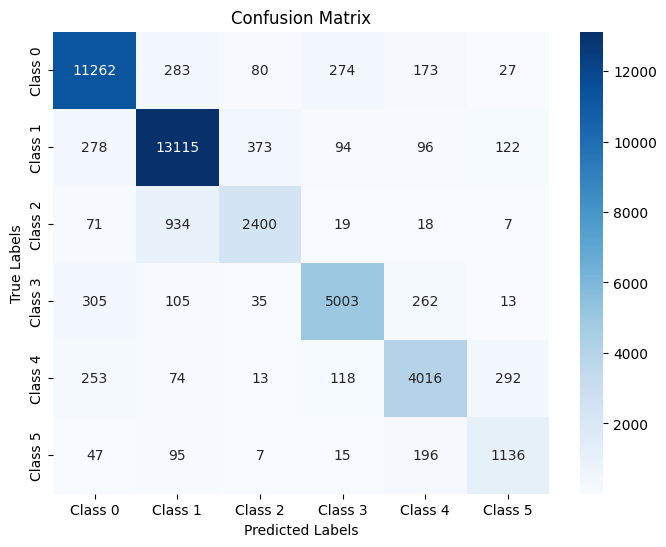


Model saved as 'tfidf_bilstm_model_9.h5'



In [ ]:
tfidf_bilstm_model_9, tfidf_bilstm_metrics_9, tfidf_bilstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_tfidf, y_train=train_data['label'],
    X_val=X_val_tfidf, y_val=val_data['label'],
    X_test=X_test_tfidf, y_test=test_data['label'],
    model_type="bilstm"
)

tfidf_bilstm_model_9.save('tfidf_bilstm_model_9.h5')
print("\nModel saved as 'tfidf_bilstm_model_9.h5'\n")